# **Ejercicio 2**

## **Librerías y módulos necesarios**

In [ ]:
import pandas as pd
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
#from rdkit import Chem
#from rdkit.Chem import Draw
from scipy.stats import kstest, norm
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from IPython.display import display
from sklearn.pipeline import Pipeline
from matplotlib.colors import LinearSegmentedColormap

# **Ejercicio 2.1: Predict New Medicines with BELKA**

## **Contextualización**

Los fármacos de moléculas pequeñas son compuestos químicos que interactúan con proteínas celulares para alterar sus funciones, generalmente inhibiendo proteínas implicadas en enfermedades. Tradicionalmente, la identificación de moléculas candidatas es un proceso largo y laborioso, ya que implica fabricarlas una por una y probar su interacción con proteínas específicas. Aunque la FDA ha aprobado alrededor de 2.000 nuevas moléculas, se estima que existen 10^60 productos químicos potenciales en el espacio farmacológico, lo que hace imposible buscarlos físicamente. Por ello, se necesitan métodos más eficientes para descubrir tratamientos escondidos en este vasto espacio químico.

<div style="text-align: center;">
    <img src="https://github.com/kmarcela11/Parcial1_MachineLearning/blob/main/Imagen.jpg?raw=true" alt= " " width="600"/>
</div>


### **Objetivos**

- Aplicar técnicas de machine learning para predecir si una molécula pequeña se unirá a proteínas específicas, utilizando modelos bien entrenados que permitan evitar experimentos de laboratorio costosos y lentos.
- Analizar diferentes tipos de moléculas para determinar si se adhieren o no a las proteínas objetivo, mejorando la comprensión de su interacción.
- Predecir si una molécula es aglutinante o no de una proteína, es decir, si la molécula se adhiere a las tres proteínas de interés que se están estudiando.

### **Datos importantes**

- Este proyecto selecciona tres proteínas diana clave: EPHX2 (sEH), BRD4, y ALB (HSA). EPHX2/sEH es una hidrolasa implicada en la hipertensión y la diabetes, que ha sido un objetivo farmacológico en ensayos clínicos. BRD4 es un bromodominio que afecta la transcripción genética y desempeña un papel en la progresión del cáncer, habiendo sido evaluado previamente para indicaciones oncológicas. ALB, también conocida como albúmina sérica humana, es la proteína más abundante en la sangre y juega un papel importante en la absorción y transporte de fármacos, siendo clave para mejorar la eficacia de los tratamientos farmacológicos.
- Los ejemplos en el conjunto de datos están representados por una clasificación binaria de si una molécula pequeña dada es un aglutinante o no de una de las tres proteínas objetivo.
- La química está representada por SMILES (Simplified Molecular-Input Line-Entry System) y las etiquetas como clasificaciones de unión binaria, una por proteína diana.
- Para este ejercicio, se cuenta con dos bases de datos: `train`y `test`. En este ejercicio solo será usada la base de datos correspondiente al `train` dado que el `test` solo contiene información sobre las características de las moléculas y no la etiqueta binaria que indica si la molécula se une a la proteína (es decir, no tiene variable objetivo)

### **Diccionario de variables**


| Variable              | Descripción                                                                                       |
|-----------------------|---------------------------------------------------------------------------------------------------|
|`id`                | Un example_id único que identifica el par de dianas de unión a la molécula.                        |
| `buildingblock1_smiles` | La estructura, en SMILES, del primer bloque de construcción.                                     |
| `buildingblock2_smiles` | La estructura, en SMILES, del segundo bloque de construcción.                                    |
| `buildingblock3_smiles` | La estructura, en SMILES, del tercer bloque de construcción.                                     |
| `molecule_smiles`    | La estructura completa de la molécula ensamblada, en SMILES. Esto incluye los tres bloques de construcción y el núcleo de triazina. Se usa 'a' como sustituto del enlazador de ADN. |
| `protein_name`       | El nombre de la proteína objetivo.                                                                 |
| `binds`              | La columna de destino. Una etiqueta de clase binaria que indica si la molécula se une a la proteína. No disponible en el conjunto de prueba. |

## **Base de datos**

Inicialmente se hace el cargue del conjunto de datos de entrenamiento, con el uso de la librería `pandas` y el módulo **`read_parquet`** para leer el archivo en formato `Parquet`. El formato Parquet es usado para almacenar y comprimir grandes volúmenes de datos, optimizando  el uso del espacio.

En este caso, se utiliza el parámetro `engine = 'pyarrow'` que indica que se usará la biblioteca **PyArrow** como motor para la lectura del archivo Parquet. PyArrow es preferido por su velocidad y eficiencia al manejar grandes conjuntos de datos.


In [6]:
# data = pd.read_parquet('train.parquet', engine = 'pyarrow')
data = pd.read_parquet('C:/Users/kamac/OneDrive/Desktop/MachineLearningUN/train.parquet')

En esta parte, se busca visualizar las estructuras moleculares que componen los datos químicos utilizando el formato SMILES.


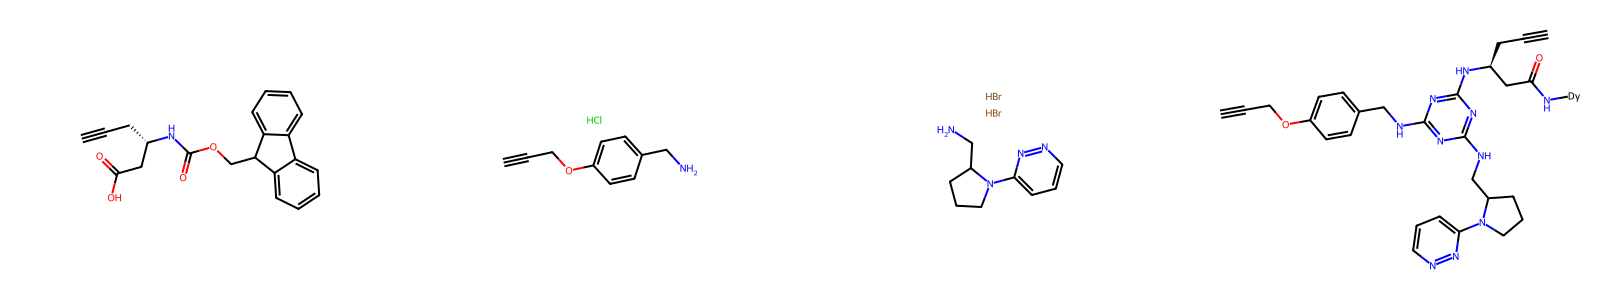

In [9]:
def moleculas(data, cantidad):
    data_mol = data.reset_index(drop = True)
    mols = []
    for i in range(cantidad):
        mols += [Chem.MolFromSmiles(data_mol['buildingblock1_smiles'][i]),Chem.MolFromSmiles(data_mol['buildingblock2_smiles'][i]),
                  Chem.MolFromSmiles(data_mol['buildingblock3_smiles'][i]),Chem.MolFromSmiles(data_mol['molecule_smiles'][i])]
    return Draw.MolsToGridImage(mols, molsPerRow=4, subImgSize=(400,300))

moleculas(data, 1)

Al ver la imagen es posible observar cómo están conformadas las moléculas a partir de sus bloques de construcción individuales y la molécula completa ensamblada.


### **Características de la base de datos**



Entender la estructura de la base de datos y la naturaleza de la información es fundamental para poder visualizar los datos de manera efectiva. Por esta razón, en esta sección se examinarán la dimensión de la base de datos y los diferentes tipos de variables que se encuentran en ella.

Inicialmente se hace uso del método `.head(9)` para indicar que se muestren las 9 primeras observaciones de la base de datos.

In [ ]:
data.head(9)

,id,buildingblock1_smiles,buildingblock2_smiles,buildingblock3_smiles,molecule_smiles,protein_name,binds
0,0,C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21,C#CCOc1ccc(CN)cc1.Cl,Br.Br.NCC1CCCN1c1cccnn1,C#CCOc1ccc(CNc2nc(NCC3CCCN3c3cccnn3)nc(N[C@@H]...,BRD4,0
1,1,C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21,C#CCOc1ccc(CN)cc1.Cl,Br.Br.NCC1CCCN1c1cccnn1,C#CCOc1ccc(CNc2nc(NCC3CCCN3c3cccnn3)nc(N[C@@H]...,HSA,0
2,2,C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21,C#CCOc1ccc(CN)cc1.Cl,Br.Br.NCC1CCCN1c1cccnn1,C#CCOc1ccc(CNc2nc(NCC3CCCN3c3cccnn3)nc(N[C@@H]...,sEH,0
3,3,C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21,C#CCOc1ccc(CN)cc1.Cl,Br.NCc1cccc(Br)n1,C#CCOc1ccc(CNc2nc(NCc3cccc(Br)n3)nc(N[C@@H](CC...,BRD4,0
4,4,C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21,C#CCOc1ccc(CN)cc1.Cl,Br.NCc1cccc(Br)n1,C#CCOc1ccc(CNc2nc(NCc3cccc(Br)n3)nc(N[C@@H](CC...,HSA,0
5,5,C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21,C#CCOc1ccc(CN)cc1.Cl,Br.NCc1cccc(Br)n1,C#CCOc1ccc(CNc2nc(NCc3cccc(Br)n3)nc(N[C@@H](CC...,sEH,0
6,6,C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21,C#CCOc1ccc(CN)cc1.Cl,C#CCOc1ccc(CN)cc1.Cl,C#CCOc1ccc(CNc2nc(NCc3ccc(OCC#C)cc3)nc(N[C@@H]...,BRD4,0
7,7,C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21,C#CCOc1ccc(CN)cc1.Cl,C#CCOc1ccc(CN)cc1.Cl,C#CCOc1ccc(CNc2nc(NCc3ccc(OCC#C)cc3)nc(N[C@@H]...,HSA,0
8,8,C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21,C#CCOc1ccc(CN)cc1.Cl,C#CCOc1ccc(CN)cc1.Cl,C#CCOc1ccc(CNc2nc(NCc3ccc(OCC#C)cc3)nc(N[C@@H]...,sEH,0


Al visualizar las primeras 9 observaciones, se puede identificar un patrón claro: los valores de las variables correspondientes a los bloques de construcción y los nombres de las moléculas se repiten tres veces. Esto ocurre porque cada molécula se evalúa con los tres tipos de proteínas objetivo. Esta repetición refleja la estructura del experimento, en el que se analiza cómo la misma molécula interactúa de manera diferente con cada una de las tres proteínas,

Con el uso del método `info()` y `shape` se puede observar una visión general de las características de la base de datos.

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 295246830 entries, 0 to 295246829
Data columns (total 7 columns):
 #   Column                 Dtype 
---  ------                 ----- 
 0   id                     int64 
 1   buildingblock1_smiles  object
 2   buildingblock2_smiles  object
 3   buildingblock3_smiles  object
 4   molecule_smiles        object
 5   protein_name           object
 6   binds                  int64 
dtypes: int64(2), object(5)
memory usage: 15.4+ GB


In [ ]:
data.shape

(295246830, 7)

En este caso, la base de datos de entrenamiento tiene **29,524,683** observaciones y **7 columnas** en total. Las columnas  incluyen:
- **id**: Identificador único (tipo entero).
- **buildingblock1_smiles**, **buildingblock2_smiles**, **buildingblock3_smiles**, **molecule_smiles**: Representaciones moleculares en formato SMILES (tipo cadena).
- **protein_name**: Nombre de la proteína objetivo (tipo cadena).
- **binds**: Etiqueta binaria que indica si la molécula se une a la proteína (tipo entero).



In [ ]:
data.describe(include = object)

,buildingblock1_smiles,buildingblock2_smiles,buildingblock3_smiles,molecule_smiles,protein_name
count,295246830,295246830,295246830,295246830,295246830
unique,271,693,872,98415610,3
top,O=C(N[C@H]1CC[C@@H](C(=O)O)C1)OCC1c2ccccc2-c2c...,NCc1ccccn1,NCCc1nccc(C2CC2)n1,[N-]=[N+]=NCCC[C@H](Nc1nc(Nc2noc3ccc(F)cc23)nc...,BRD4
freq,1090407,706092,562191,3,98415610


Al aplicar el método `describe(include=object)`, se observaron las siguientes características de las columnas categóricas:

- Las columnas `buildingblock1_smiles`, `buildingblock2_smiles`, y `buildingblock3_smiles` contienen entre **271** y **872** representaciones moleculares únicas, con valores más frecuentes que aparecen hasta **1,090,407** veces.
  
- La columna **`molecule_smiles`** muestra una alta diversidad con más de **98 millones** de combinaciones únicas, aunque el valor más frecuente aparece solo **3 veces**. Lo que corresponde a que cada molécula está asociada a tres proteínas.

- En **`protein_name`**, hay **3** proteínas únicas, siendo **`BRD4`** la más común, con aproximadamente **9.8 millones** de apariciones.

Se utiliza el método `.value_counts()` para analizar la distribución de la variable objetivo **`binds`**, que indica si una molécula se une a una proteína o no.

In [ ]:
data['binds'].value_counts()

,count
binds,
0,293656924
1,1589906


In [ ]:
binds_counts = data['binds'].value_counts(normalize = True)
binds_counts

,proportion
binds,
0,0.994615
1,0.005385


Al analizar la columna `binds`, que indica si una molécula se une a una proteína o no, encontramos una distribución muy desbalanceada. En total, se registran **29,365,692 (99.46%)** observaciones con un valor de **0**, lo que significa que la molécula **no se une** a la proteína. Por otro lado, solo **1,589,906 (0.54%)** observaciones presentan un valor de **1**, indicando que la molécula **sí se une** a la proteína.

Ahora, veamos lo anterior gráficamente.

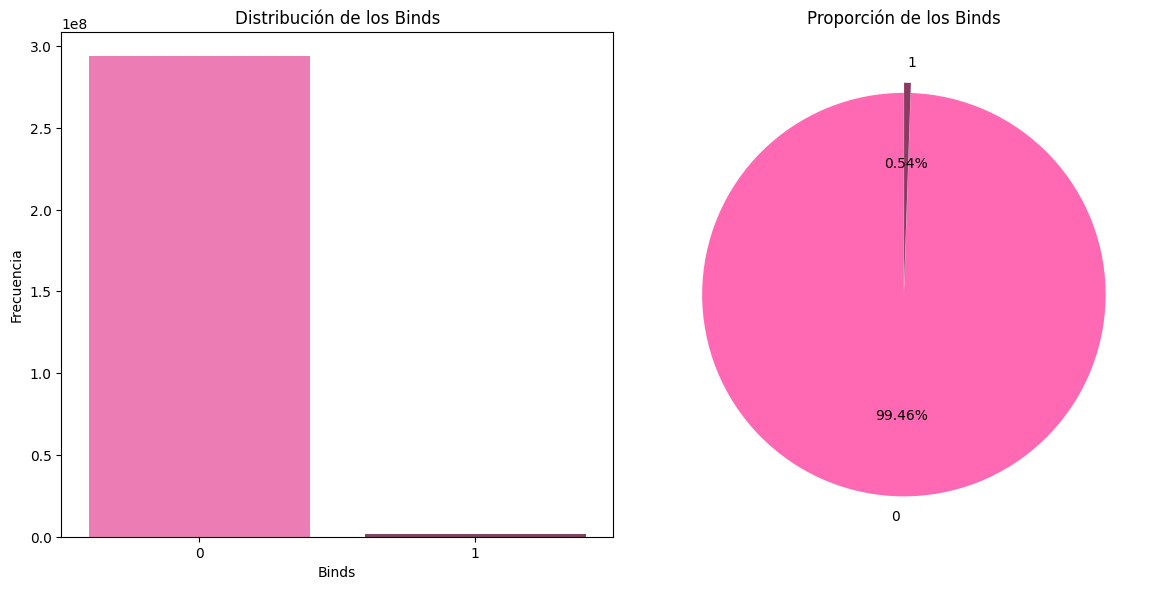

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.countplot(x = data['binds'], hue = data['binds'], palette = ['#FF69B4', '#8B3A62'], legend = False, ax=axes[0])
axes[0].set_title('Distribución de los Binds')
axes[0].set_xlabel('Binds')
axes[0].set_ylabel('Frecuencia')

binds_counts.plot(kind = 'pie', autopct = '%1.2f%%', colors = ['#FF69B4', '#8B3A62'], startangle = 90, explode = (0.05, 0), ax = axes[1])
axes[1].set_title('Proporción de los Binds')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()



In [ ]:
data_copy = data.copy()

En efecto, al ver dos tipos de gráficos para la representación de esta variable, notamos que hay una gran diferencia entre los dos grupos. La clase **0**, que indica que la molécula no se une a la proteína, representa la mayoría de los datos, mientras que la clase **1**, que indica que sí hay unión, es una pequeña parte del total.


### **Datos faltantes**

En esta parte se realiza un análisis para identificar la cantidad de datos faltantes en cada columna de la base de datos. Se utiliza la librería `missingno` para generar una visualización en forma de barra que muestra el porcentaje de datos faltantes en cada columna, ordenados de manera ascendente.

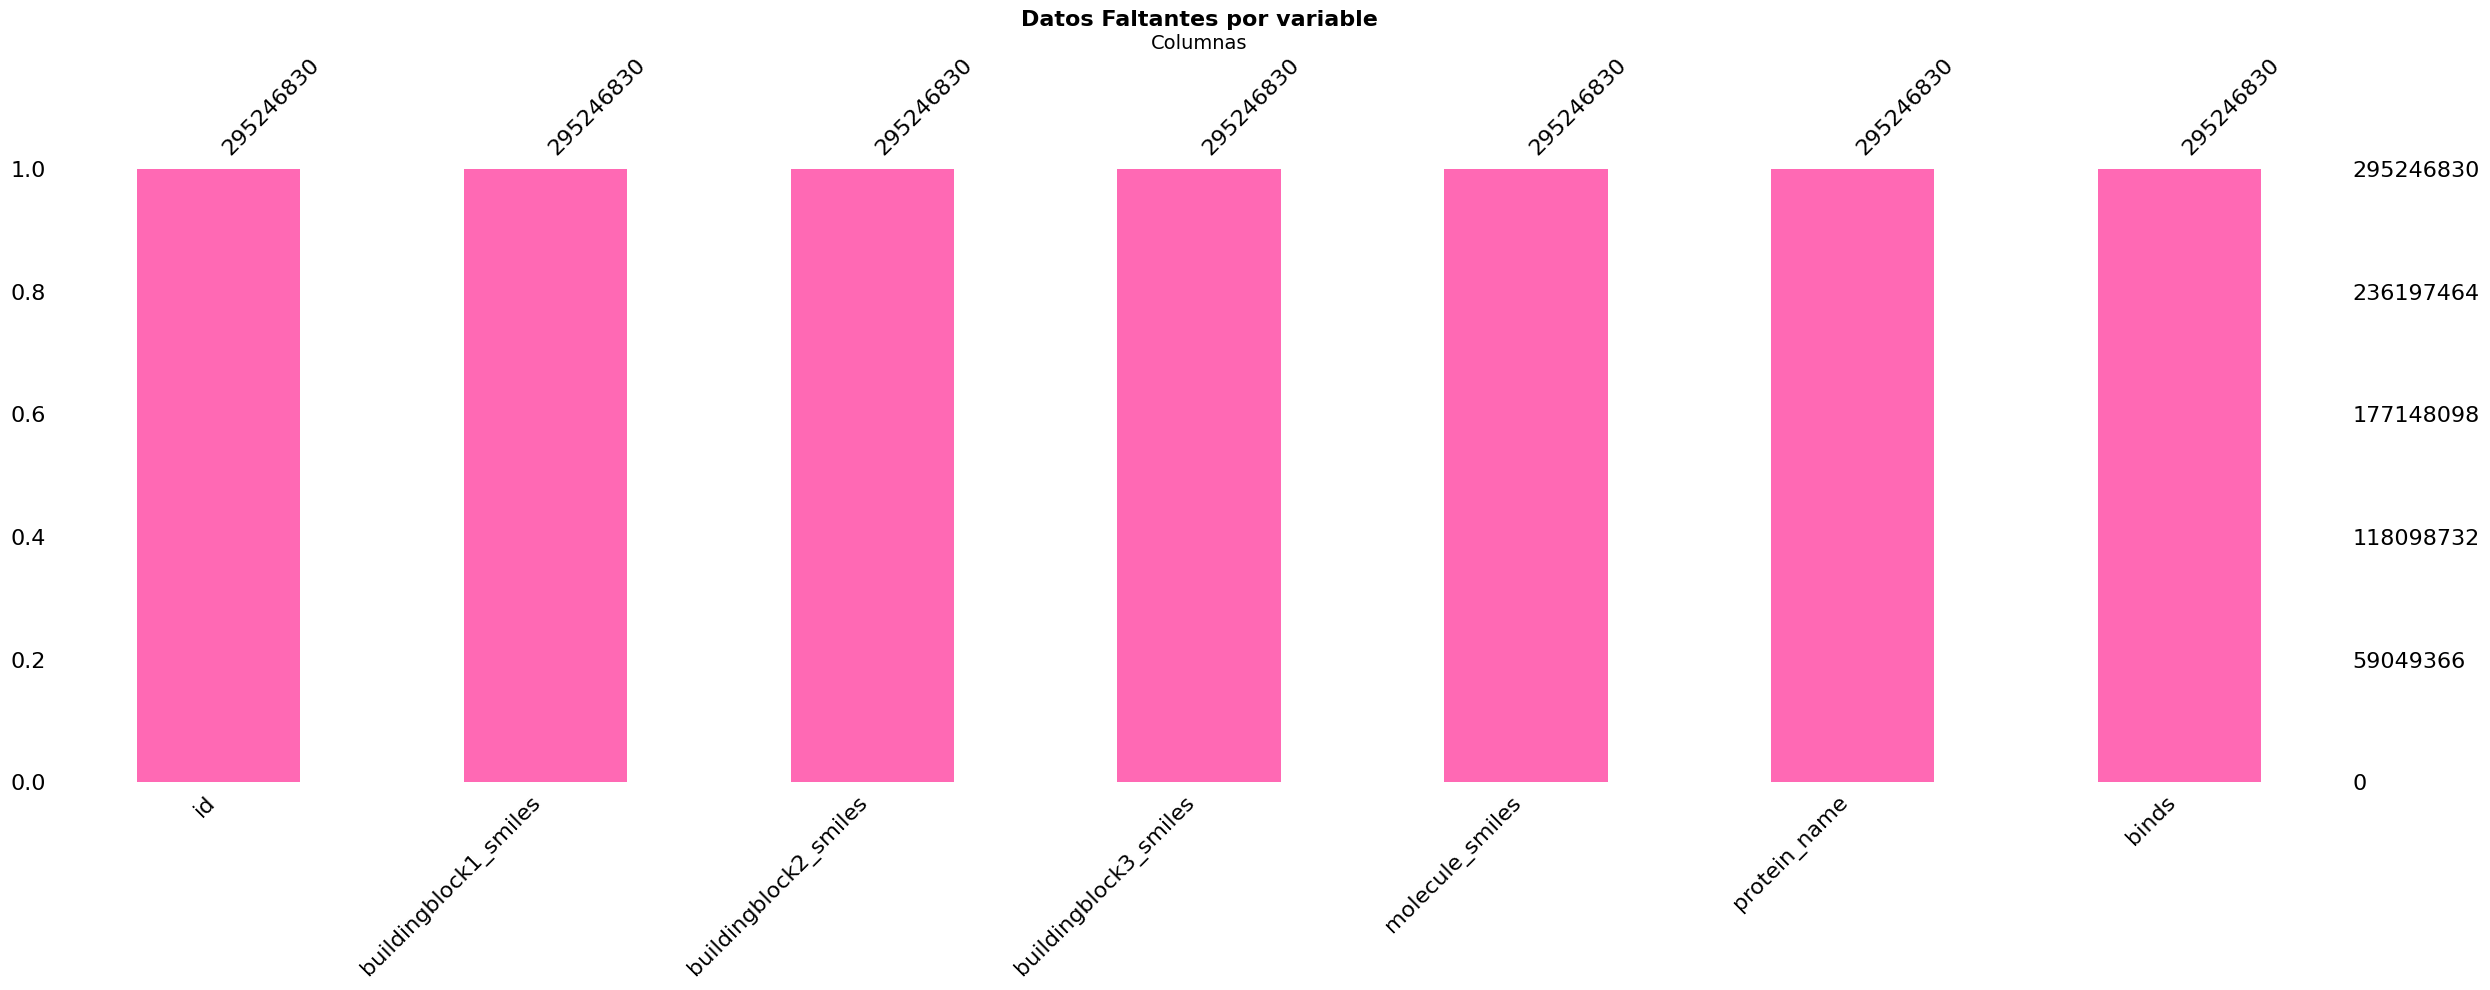

In [ ]:
msno.bar(data, color = "#FF69B4", sort = 'ascending')
plt.title('Datos Faltantes por variable', fontsize = 16, fontweight = 'bold')
plt.xlabel('Columnas', fontsize = 14)
plt.ylabel('Porcentaje de Datos Faltantes', fontsize = 14)
plt.xticks(rotation = 45)
plt.tight_layout()
plt.show()

El gráfico muestra que no hay datos faltantes en ninguna de las variables (`Id`, `buildingblock1_smiles`, `buildingblock2_smiles` etc.), ya que todas las barras está llenas. Esto indica que las columnas están completas y no presentan valores nulos o faltantes, lo cual es bueno para predecir de manera más precisa nuestro modelo.

### **Filtración de la base de datos por proteínas**

Dada la alta cantidad de datos existentes en la base de datos y la complejidad computacional que esta requiere para realizar los diferentes tipos de modelación y transformación de datos, en esta sección se filtrará la base de datos por el tipo de proteína y a su vez se usarán solo 50.000 observaciones, las cuales son seleccionadas de manera estratificada para no perder el balance que hay en cada clase.

Inicialmente comenzamos agrupando los nombres de los tres tipos de proteínas y contando los valores que existen en cada una de ellas para ver si son aglutinantes a las moléculas o no (0: No se une, 1: Se unen). Luego se muestran en forma de proporción

In [ ]:
proteinas = data.groupby('protein_name')['binds'].value_counts(normalize=True).unstack().reset_index()
proteinas

binds,protein_name,0,1
0,BRD4,0.995357,0.004643
1,HSA,0.995850,0.004150
2,sEH,0.992638,0.007362


Nótese que en todas las proteínas, la mayor proporción se encuentra en la categoría 0, con valores cercanos a 0.99, mientras que la categoría 1 tiene valores mucho más pequeños. Esto puede indicar un desbalance en el momento de aplicar los modelos. Por último, es posible afirmar que de los tres tipos de proteína la que se encuentra menos desbalanceada es `sEH`, dado que la diferencia entre las proporciones de las categorías 0 (0.992638) y 1 (0.007362) es ligeramente menor en comparación con las otras proteínas, lo que indica una distribución un poco más balanceada.

Ahora se generan tres nuevas bases de datos, cada una filtrada por un tipo de proteína específico. A cada conjunto de datos se le aplicará un análisis separado para determinar cuál modelo se desempeña mejor con cada tipo de proteína. Este enfoque permite comparar los resultados y evaluar cuál proteína responde mejor a los diferentes modelos de clasificación.

In [ ]:
data_proteina1 = data[data['protein_name'] == 'sEH']
data_proteina2 = data[data['protein_name'] == 'BRD4']
data_proteina3 = data[data['protein_name'] == 'HSA']

#### **Proteína SEH (EPHX2)**

En esta parte del código, se realiza una división del conjunto de datos de la proteína `sEH` utilizando `train_test_split`. El objetivo es extraer una muestra de 100,000 filas para entrenar el modelo, manteniendo la misma proporción de la variable objetivo `binds`. Se utiliza `stratify` para asegurar que la distribución de las clases en `binds` se mantenga balanceada.

In [ ]:
data_p1, _ = train_test_split( data_proteina1, train_size = 100000,  stratify = data_proteina1['binds'],  random_state = 11)

Ahora, se observan los primeros registros del nuevo conjunto de datos (`data_p1`)y se analizan las características de las columnas categóricas, verificando la frecuencia de valores únicos y asegurando que no haya valores nulos.

In [ ]:
data_p1.head()

,id,buildingblock1_smiles,buildingblock2_smiles,buildingblock3_smiles,molecule_smiles,protein_name,binds
147239129,147239129,O=C(Nc1c(Cl)cccc1C(=O)O)OCC1c2ccccc2-c2ccccc21,CNC(=O)COCCN.Cl,CN(CCN)C1CCOCC1,CNC(=O)COCCNc1nc(NCCN(C)C2CCOCC2)nc(Nc2c(Cl)cc...,sEH,0
257990426,257990426,O=C(O)C[C@@H](NC(=O)OCC1c2ccccc2-c2ccccc21)c1c...,Nc1cc(N2CCNCC2)ccc1[N+](=O)[O-],Cl.NCCN1CCCS1(=O)=O,O=C(C[C@@H](Nc1nc(NCCN2CCCS2(=O)=O)nc(Nc2cc(N3...,sEH,0
180571076,180571076,O=C(Nc1ccc(Br)c(C(=O)O)c1)OCC1c2ccccc2-c2ccccc21,NCc1ccc2[nH]ccc2c1,Cc1ccc(N)nn1,Cc1ccc(Nc2nc(NCc3ccc4[nH]ccc4c3)nc(Nc3ccc(Br)c...,sEH,0
186946937,186946937,O=C(Nc1ccc(C(=O)O)c([N+](=O)[O-])c1)OCC1c2cccc...,Cl.NCc1ccc(-c2c[nH]c(=O)[nH]c2=O)cc1,Nc1ccsc1.O=C(O)C(=O)O,O=C(N[Dy])c1ccc(Nc2nc(NCc3ccc(-c4c[nH]c(=O)[nH...,sEH,0
207543668,207543668,O=C(Nc1cccc(-c2cccc(C(=O)O)c2)c1O)OCC1c2ccccc2...,Cl.NCC(=O)N1CCCO1,Nc1c(O)ncnc1O,O=C(N[Dy])c1cccc(-c2cccc(Nc3nc(NCC(=O)N4CCCO4)...,sEH,0


In [ ]:
data_p1.describe(include = object)

,buildingblock1_smiles,buildingblock2_smiles,buildingblock3_smiles,molecule_smiles,protein_name
count,100000,100000,100000,100000,100000
unique,271,693,867,100000,1
top,O=C(Nc1cc(C(=O)O)ccc1Br)OCC1c2ccccc2-c2ccccc21,CC1(CCCCN)OCCO1,CSc1nnc(CN)s1,Cc1cc(Nc2nc(Nc3ccc(C)c(Br)c3)nc(Nc3ccc([N+](=O...,sEH
freq,418,261,226,1,100000


In [ ]:
data_p1.isnull().sum()

,0
id,0
buildingblock1_smiles,0
buildingblock2_smiles,0
buildingblock3_smiles,0
molecule_smiles,0
protein_name,0
binds,0


No hay valores faltantes en el conjunto de datos. Lo cual es lo esperado, dado que en la base de datos original no habian datos filtrados. Por lo tanto, es buen indicio de que se hizo bien la filtración de los datos

Se cuenta la cantidad de ocurrencias de las clases en la variable binds para observar si hay un desbalance de clases.

In [ ]:
bind1 = data_p1['binds'].value_counts()
bind1

,count
binds,
0,99264
1,736


In [ ]:
binds1 = data_p1['binds'].value_counts(normalize = True)
binds1

,proportion
binds,
0,0.99264
1,0.00736


Existe un fuerte desbalance en la variable objetivo `binds`, donde la clase **0** domina con un **99.26%** de los datos.

Viendolo gráficamente:

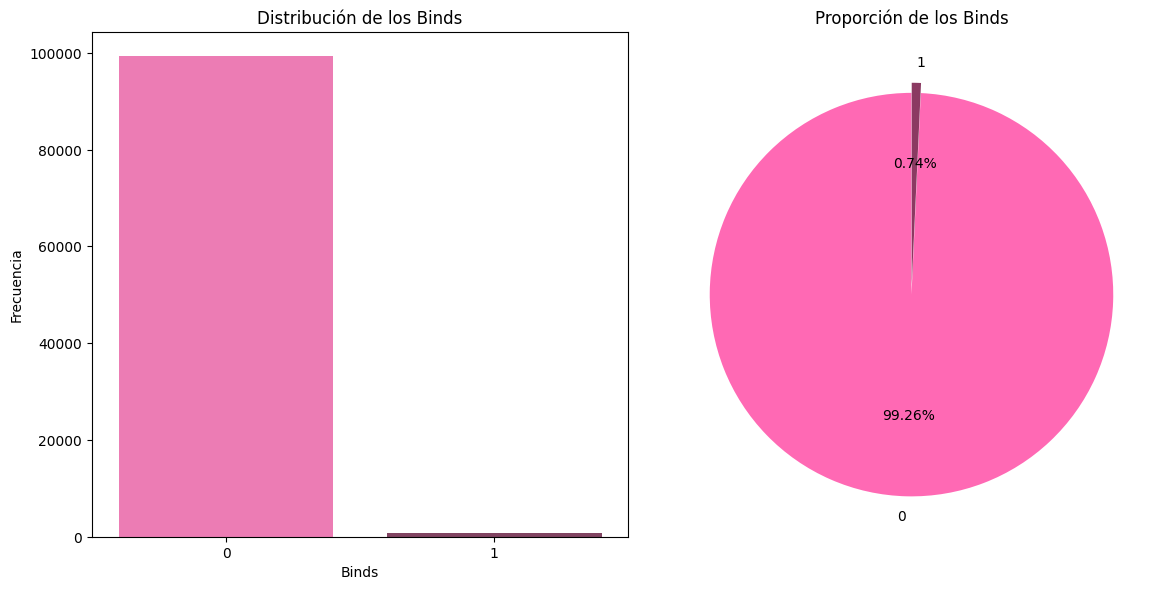

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.countplot(x = data_p1['binds'], hue = data_p1['binds'], palette = ['#FF69B4', '#8B3A62'], legend = False, ax=axes[0])
axes[0].set_title('Distribución de los Binds')
axes[0].set_xlabel('Binds')
axes[0].set_ylabel('Frecuencia')

binds1.plot(kind = 'pie', autopct = '%1.2f%%', colors = ['#FF69B4', '#8B3A62'], startangle = 90, explode = (0.05, 0), ax = axes[1])
axes[1].set_title('Proporción de los Binds')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()

 Se visualiza el desbalance de clases de manera clara, donde la clase **0** es mucho más frecuente que la clase **1**

Se utiliza `reset_index()` para reiniciar el índice del DataFrame `data_p1`

In [ ]:
data_p1 = data_p1.reset_index()

En esta parte se seleccionan las columnas categóricas (`protein_name`, `buildingblock1_smiles`, `buildingblock2_smiles`, `buildingblock3_smiles`) que contienen cadenas de texto, y se transforman en variables numéricas utilizando `OneHotEncoder`.

La codificación convierte estas columnas en variables binarias (0 o 1), donde cada valor único en una columna categórica se convierte en una nueva columna.

Finalmente, las nuevas columnas codificadas se añaden al DataFrame original y se eliminan las columnas categóricas originales.

In [ ]:
categoricas = ['protein_name', 'buildingblock1_smiles', 'buildingblock2_smiles', 'buildingblock3_smiles']
encoder1 = OneHotEncoder(sparse_output = False)  #La salida será una matriz densa (DataFrame de Pandas)
encoded1 = encoder1.fit_transform(data_p1[categoricas])
df_encoded1 = pd.DataFrame(encoded1, columns = encoder1.get_feature_names_out(categoricas))
df_proteina1 = pd.concat([data_p1, df_encoded1], axis = 1) # axis = 1: Indica que las columnas especificadas deben ser eliminadas
df_proteina1 = df_proteina1.drop(categoricas, axis = 1)

In [ ]:
df_proteina1.head()

,index,id,molecule_smiles,binds,protein_name_sEH,buildingblock1_smiles_C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21,buildingblock1_smiles_C#CC[C@@H](NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O,buildingblock1_smiles_C#CC[C@@](C)(NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O,buildingblock1_smiles_C#CC[C@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21,buildingblock1_smiles_C#CC[C@H](NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O,...,buildingblock3_smiles_Nc1ncnc(=O)[nH]1,buildingblock3_smiles_Nc1ncnc(Cl)c1Cl,buildingblock3_smiles_Nc1ncnc2[nH]cnc12,buildingblock3_smiles_Nc1ncnc2[nH]ncc12,buildingblock3_smiles_Nc1ncnc2c1ncn2C1CCCCO1,buildingblock3_smiles_Nc1ncncc1Br,buildingblock3_smiles_Nc1nnc(S)s1,buildingblock3_smiles_Nc1nncs1,buildingblock3_smiles_Nc1nnn[nH]1,buildingblock3_smiles_Nc1noc2ccc(F)cc12
0,147239129,147239129,CNC(=O)COCCNc1nc(NCCN(C)C2CCOCC2)nc(Nc2c(Cl)cc...,0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,257990426,257990426,O=C(C[C@@H](Nc1nc(NCCN2CCCS2(=O)=O)nc(Nc2cc(N3...,0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,180571076,180571076,Cc1ccc(Nc2nc(NCc3ccc4[nH]ccc4c3)nc(Nc3ccc(Br)c...,0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,186946937,186946937,O=C(N[Dy])c1ccc(Nc2nc(NCc3ccc(-c4c[nH]c(=O)[nH...,0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,207543668,207543668,O=C(N[Dy])c1cccc(-c2cccc(Nc3nc(NCC(=O)N4CCCO4)...,0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Las variables categóricas han sido correctamente transformadas en variables binarias (0 y 1).

In [ ]:
df_proteina1.shape

(100000, 1836)

Luego de haber codificado las variables categóricas, la base de datos cuenta con **100.000** filas y **1836** columnas

Verifiquemos que no se hayan generado datos faltantes con la codificación de las variables categóricas.

In [ ]:
missing_columns1 = df_proteina1.isnull().sum()
missing_columns1= missing_columns1[missing_columns1 > 0]
print(f"Número de columnas con datos faltantes: {len(missing_columns1)}")

Número de columnas con datos faltantes: 0


En efecto, no hay datos faltantes.


En esta parte del código se eliminan las columnas `molecule_smiles` e `id`. Estas columnas no son necesarias para el modelo, ya que no aportan información relevante para la clasificación. La columna `molecule_smiles` es una cadena compleja que no es sencilla de codificar, dado la cantidad de registros únicos que esta variable presenta. Además, esta columna es una construcción de los tres bloques que ya fueron codificados, por lo que no aporta nueva información. Por otro lado, las columna `id` e `index` es simplemente un identificador de las observaciones y no tienen valor predictivo.

In [ ]:
df_proteina1.drop(columns = ['molecule_smiles'], inplace = True)
df_proteina1.drop(columns = ['id'], inplace = True)
df_proteina1.drop(columns = ['index'], inplace = True)

En esta parte del código, se lleva a cabo la selección de características y la definición de la variable objetivo

Se aplica SelectKBest con la función de chi-cuadrado (chi2) para seleccionar las 100 mejores características que tienen una relación más fuerte con la variable objetivo. Este proceso selecciona solo aquellas características que son más relevantes para la clasificación.

In [ ]:
y1 = df_proteina1['binds']

# Aplicar SelectKBest con chi2 para seleccionar las mejores características
k_best1 = SelectKBest(score_func = chi2, k = 100)  # Se quieren conservar k = 100 mejores características
X_new1 = k_best1.fit_transform(df_proteina1, y1)

selected_features = k_best1.get_support(indices=True)  # Obtener los índices de las características seleccionadas
proteina1 = df_proteina1.iloc[:, selected_features]

In [ ]:
proteina1.head()

,binds,buildingblock1_smiles_O=C(NC(Cc1ccccc1)C(=O)O)OCC1c2ccccc2-c2ccccc21,buildingblock1_smiles_O=C(NCC1CCC(C(=O)O)CC1)OCC1c2ccccc2-c2ccccc21,buildingblock1_smiles_O=C(NC[C@H]1CC[C@H](C(=O)O)CC1)OCC1c2ccccc2-c2ccccc21,buildingblock1_smiles_O=C(N[C@@H](Cc1cccnc1)C(=O)O)OCC1c2ccccc2-c2ccccc21,buildingblock1_smiles_O=C(N[C@H](Cc1ccc(F)c(F)c1)C(=O)O)OCC1c2ccccc2-c2ccccc21,buildingblock1_smiles_O=C(Nc1ccc(C(=O)O)cc1)OCC1c2ccccc2-c2ccccc21,buildingblock1_smiles_O=C(Nc1ccc(C(=O)O)cc1O)OCC1c2ccccc2-c2ccccc21,buildingblock1_smiles_O=C(Nc1ccc(C(=O)O)nc1)OCC1c2ccccc2-c2ccccc21,buildingblock1_smiles_O=C(Nc1cnccc1C(=O)O)OCC1c2ccccc2-c2ccccc21,...,buildingblock3_smiles_Nc1c2c(cc3c1CCC3)CCC2,buildingblock3_smiles_Nc1cc(C(F)(F)F)cc(C(F)(F)F)c1,buildingblock3_smiles_Nc1cc(Cl)ccc1F,buildingblock3_smiles_Nc1cc(F)c(F)cc1[N+](=O)[O-],buildingblock3_smiles_Nc1ccc2c(c1)CNCC2,buildingblock3_smiles_Nc1cccc2ocnc12,buildingblock3_smiles_Nc1cncc(F)c1,buildingblock3_smiles_Nc1n[nH]c2ccc([N+](=O)[O-])cc12,buildingblock3_smiles_Nc1nc(NCc2ccc(F)cc2)ccc1[N+](=O)[O-],buildingblock3_smiles_Nc1ncco1
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
proteina1.shape

(100000, 100)

Finalmente, la base de datos `proteina1` esta lista para ser usada en los diferentes modelos de clasificación. Esta base de datos cuenta con **100.000** filas y **100** columnas

#### **Proteína BRD4**

En esta parte del código, se realiza una división del conjunto de datos de la proteína `BRD4` utilizando `train_test_split`. El objetivo es extraer una muestra de 100,000 filas para entrenar el modelo, manteniendo la misma proporción de la variable objetivo `binds`. Se utiliza `stratify` para asegurar que la distribución de las clases en `binds` se mantenga balanceada.

In [ ]:
data_p2, _ = train_test_split( data_proteina2, train_size = 100000,  stratify = data_proteina2['binds'],  random_state = 11)

Ahora, se observan los primeros registros del nuevo conjunto de datos (`data_p2`)y se analizan las características de las columnas categóricas, verificando la frecuencia de valores únicos y asegurando que no haya valores nulos.

In [ ]:
data_p2.head()

,id,buildingblock1_smiles,buildingblock2_smiles,buildingblock3_smiles,molecule_smiles,protein_name,binds
100174431,100174431,O=C(N[C@@H](Cc1ccc(F)cc1F)C(=O)O)OCC1c2ccccc2-...,Nc1nc(-c2cccnc2)cs1,Cc1nnsc1CN,Cc1nnsc1CNc1nc(Nc2nc(-c3cccnc3)cs2)nc(N[C@@H](...,BRD4,0
288634638,288634638,O=C(O)[C@H]1CC2CCCCC2N1C(=O)OCC1c2ccccc2-c2ccc...,Nc1ccncc1[N+](=O)[O-],Nc1nc2nc[nH]c2c(=O)[nH]1,O=C(N[Dy])[C@H]1CC2CCCCC2N1c1nc(Nc2nc3nc[nH]c3...,BRD4,0
43808760,43808760,C[C@@H](OCc1ccccc1)[C@H](NC(=O)OCC1c2ccccc2-c2...,COc1c(F)cc(N)cc1F,Nc1ccc(F)cc1CO,COc1c(F)cc(Nc2nc(Nc3ccc(F)cc3CO)nc(N[C@H](C(=O...,BRD4,0
91037118,91037118,O=C(N[C@@H](Cc1c(F)c(F)c(F)c(F)c1F)C(=O)O)OCC1...,Cl.NCCOC1CCS(=O)(=O)C1,Cl.Cl.NCCc1nnc2c(=O)[nH]ccn12,O=C(N[Dy])[C@H](Cc1c(F)c(F)c(F)c(F)c1F)Nc1nc(N...,BRD4,0
3471777,3471777,C#CC[C@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21,COC(=O)c1scnc1N,NCC1CSCCN1Cc1ccccc1,C#CC[C@H](CC(=O)N[Dy])Nc1nc(NCC2CSCCN2Cc2ccccc...,BRD4,0


In [ ]:
data_p2.describe(include = object)

,buildingblock1_smiles,buildingblock2_smiles,buildingblock3_smiles,molecule_smiles,protein_name
count,100000,100000,100000,100000,100000
unique,271,693,871,100000,1
top,O=C(N[C@@H](Cc1cc(F)c(F)c(F)c1)C(=O)O)OCC1c2cc...,NCCC(=O)NC1CCCC1,Cc1cc2cc(CN)ccc2[nH]1,Cc1ccc(C)c(CNc2nc(NCC3CCN(C(N)=O)C3)nc(Nc3ccc(...,BRD4
freq,436,272,233,1,100000


In [ ]:
data_p2.isnull().sum()

,0
id,0
buildingblock1_smiles,0
buildingblock2_smiles,0
buildingblock3_smiles,0
molecule_smiles,0
protein_name,0
binds,0


No hay valores faltantes en el conjunto de datos. Lo cual es lo esperado, dado que en la base de datos original no habian datos filtrados. Por lo tanto, es buen indicio de que se hizo bien la filtración de los datos

Se cuenta la cantidad de ocurrencias de las clases en la variable binds para observar si hay un desbalance de clases.

In [ ]:
bind2 = data_p2['binds'].value_counts()
bind2

,count
binds,
0,99536
1,464


In [ ]:
binds2 = data_p2['binds'].value_counts(normalize = True)
binds2

,proportion
binds,
0,0.99536
1,0.00464


Existe un fuerte desbalance en la variable objetivo `binds`, donde la clase **0** domina con un **99.54%** de los datos.

Viendolo gráficamente:

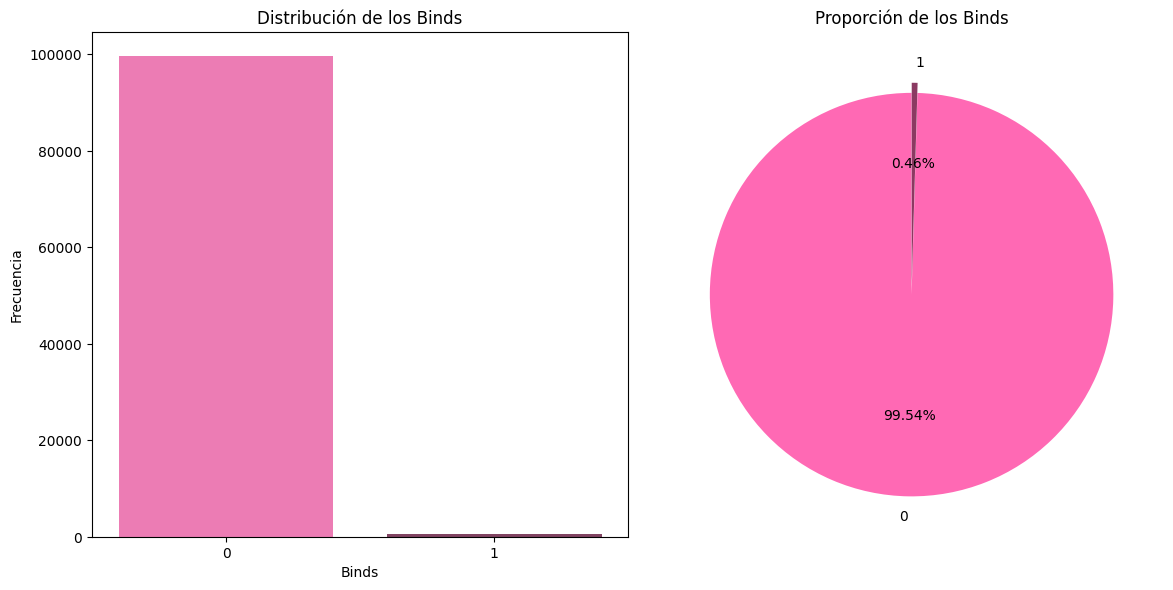

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.countplot(x = data_p2['binds'], hue = data_p2['binds'], palette = ['#FF69B4', '#8B3A62'], legend = False, ax=axes[0])
axes[0].set_title('Distribución de los Binds')
axes[0].set_xlabel('Binds')
axes[0].set_ylabel('Frecuencia')

binds2.plot(kind = 'pie', autopct = '%1.2f%%', colors = ['#FF69B4', '#8B3A62'], startangle = 90, explode = (0.05, 0), ax = axes[1])
axes[1].set_title('Proporción de los Binds')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()

 Se visualiza el desbalance de clases de manera clara, donde la clase **0** es mucho más frecuente que la clase **1**

Se utiliza `reset_index()` para reiniciar el índice del DataFrame `data_p2`

In [ ]:
data_p2 = data_p2.reset_index()

En esta parte se seleccionan las columnas categóricas (`protein_name`, `buildingblock1_smiles`, `buildingblock2_smiles`, `buildingblock3_smiles`) que contienen cadenas de texto, y se transforman en variables numéricas utilizando `OneHotEncoder`.

La codificación convierte estas columnas en variables binarias (0 o 1), donde cada valor único en una columna categórica se convierte en una nueva columna.

Finalmente, las nuevas columnas codificadas se añaden al DataFrame original y se eliminan las columnas categóricas originales.

In [ ]:
categoricas = ['protein_name', 'buildingblock1_smiles', 'buildingblock2_smiles', 'buildingblock3_smiles']
encoder2 = OneHotEncoder(sparse_output = False)
encoded2 = encoder2.fit_transform(data_p2[categoricas])
df_encoded2 = pd.DataFrame(encoded2, columns = encoder2.get_feature_names_out(categoricas))
df_proteina2 = pd.concat([data_p2, df_encoded2], axis = 1)
df_proteina2 = df_proteina2.drop(categoricas, axis = 1)

In [ ]:
df_proteina2.head()

,index,id,molecule_smiles,binds,protein_name_BRD4,buildingblock1_smiles_C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21,buildingblock1_smiles_C#CC[C@@H](NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O,buildingblock1_smiles_C#CC[C@@](C)(NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O,buildingblock1_smiles_C#CC[C@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21,buildingblock1_smiles_C#CC[C@H](NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O,...,buildingblock3_smiles_Nc1ncnc(=O)[nH]1,buildingblock3_smiles_Nc1ncnc(Cl)c1Cl,buildingblock3_smiles_Nc1ncnc2[nH]cnc12,buildingblock3_smiles_Nc1ncnc2[nH]ncc12,buildingblock3_smiles_Nc1ncnc2c1ncn2C1CCCCO1,buildingblock3_smiles_Nc1ncncc1Br,buildingblock3_smiles_Nc1nnc(S)s1,buildingblock3_smiles_Nc1nncs1,buildingblock3_smiles_Nc1nnn[nH]1,buildingblock3_smiles_Nc1noc2ccc(F)cc12
0,100174431,100174431,Cc1nnsc1CNc1nc(Nc2nc(-c3cccnc3)cs2)nc(N[C@@H](...,0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,288634638,288634638,O=C(N[Dy])[C@H]1CC2CCCCC2N1c1nc(Nc2nc3nc[nH]c3...,0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,43808760,43808760,COc1c(F)cc(Nc2nc(Nc3ccc(F)cc3CO)nc(N[C@H](C(=O...,0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,91037118,91037118,O=C(N[Dy])[C@H](Cc1c(F)c(F)c(F)c(F)c1F)Nc1nc(N...,0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3471777,3471777,C#CC[C@H](CC(=O)N[Dy])Nc1nc(NCC2CSCCN2Cc2ccccc...,0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Las variables categóricas han sido correctamente transformadas en variables binarias (0 y 1).

In [ ]:
df_proteina2.shape

(100000, 1840)

Luego de haber codificado las variables categóricas, la base de datos cuenta con **100.000** filas y **1840** columnas

Verifiquemos que no se hayan generado datos faltantes con la codificación de las variables categóricas.

In [ ]:
missing_columns2 = df_proteina2.isnull().sum()
missing_columns2 = missing_columns2[missing_columns2 > 0]
print(f"Número de columnas con datos faltantes: {len(missing_columns2)}")

Número de columnas con datos faltantes: 0


En efecto, no hay datos faltantes.


En esta parte del código se eliminan las columnas `molecule_smiles` e `id`. Estas columnas no son necesarias para el modelo, ya que no aportan información relevante para la clasificación. La columna `molecule_smiles` es una cadena compleja que no es sencilla de codificar, dado la cantidad de registros únicos que esta variable presenta. Además, esta columna es una construcción de los tres bloques que ya fueron codificados, por lo que no aporta nueva información. Por otro lado, las columna `id` e `index` es simplemente un identificador de las observaciones y no tienen valor predictivo.

In [ ]:
df_proteina2.drop(columns = ['molecule_smiles'], inplace = True)
df_proteina2.drop(columns = ['id'], inplace = True)
df_proteina2.drop(columns = ['index'], inplace = True)

En esta parte del código, se lleva a cabo la selección de características y la definición de la variable objetivo

Se aplica SelectKBest con la función de chi-cuadrado (chi2) para seleccionar las 100 mejores características que tienen una relación más fuerte con la variable objetivo. Este proceso selecciona solo aquellas características que son más relevantes para la clasificación.

In [ ]:
y2 = df_proteina2['binds']
k_best2 = SelectKBest(score_func = chi2, k = 100)
X_new2 = k_best2.fit_transform(df_proteina2, y2)

selected_features = k_best2.get_support(indices=True)
proteina2 = df_proteina2.iloc[:, selected_features]

In [ ]:
proteina2.head()

,binds,buildingblock1_smiles_CC(C)(C)OC(=O)CCC(NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O,buildingblock1_smiles_CC(C)(C)OCC(NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O,buildingblock1_smiles_CC(C)CC(NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O,buildingblock1_smiles_CC(OC(C)(C)C)C(NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O,buildingblock1_smiles_Cc1ccccc1[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21,buildingblock1_smiles_N#Cc1ccc(C[C@@H](NC(=O)OCC2c3ccccc3-c3ccccc32)C(=O)O)cc1,buildingblock1_smiles_O=C(NC(CC1CCCCC1)C(=O)O)OCC1c2ccccc2-c2ccccc21,buildingblock1_smiles_O=C(NC(CCc1ccccc1)C(=O)O)OCC1c2ccccc2-c2ccccc21,buildingblock1_smiles_O=C(NC(Cc1ccccc1)C(=O)O)OCC1c2ccccc2-c2ccccc21,...,buildingblock3_smiles_Nc1cc(Cl)c(O)c(Cl)c1,buildingblock3_smiles_Nc1cc(N2CCNCC2)ccc1[N+](=O)[O-],buildingblock3_smiles_Nc1ccc2[nH]ncc2c1,buildingblock3_smiles_Nc1ccc2c(c1)CCC2=O,buildingblock3_smiles_Nc1ccc2c(c1)CNC2=O,buildingblock3_smiles_Nc1ccc2c(c1)COC2=O,buildingblock3_smiles_Nc1cccnc1F,buildingblock3_smiles_Nc1nc2ccccc2s1,buildingblock3_smiles_Nc1nc2nc[nH]c2c(=O)[nH]1,buildingblock3_smiles_Nc1nccs1
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
proteina2.shape

(100000, 100)

Finalmente, la base de datos `proteina2` esta lista para ser usada en los diferentes modelos de clasificación. Esta base de datos cuenta con **100.000** filas y **100** columnas

#### **Proteína HSA (ALB)**

En esta parte del código, se realiza una división del conjunto de datos de la proteína `HSA` utilizando `train_test_split`. El objetivo es extraer una muestra de 100,000 filas para entrenar el modelo, manteniendo la misma proporción de la variable objetivo `binds`. Se utiliza `stratify` para asegurar que la distribución de las clases en `binds` se mantenga balanceada.

In [ ]:
data_p3, _ = train_test_split( data_proteina3, train_size = 100000,  stratify = data_proteina3['binds'],  random_state = 11)

Ahora, se observan los primeros registros del nuevo conjunto de datos (`data_p3`)y se analizan las características de las columnas categóricas, verificando la frecuencia de valores únicos y asegurando que no haya valores nulos.

In [ ]:
data_p3.head()

,id,buildingblock1_smiles,buildingblock2_smiles,buildingblock3_smiles,molecule_smiles,protein_name,binds
79451005,79451005,O=C(NC1(C(=O)O)CCCCC1)OCC1c2ccccc2-c2ccccc21,Nc1ccnc(Cl)c1,N#Cc1cccc(N)n1,N#Cc1cccc(Nc2nc(Nc3ccnc(Cl)c3)nc(NC3(C(=O)N[Dy...,HSA,0
251510695,251510695,O=C(O)C[C@@H](Cc1ccc([N+](=O)[O-])cc1)NC(=O)OC...,Nc1ccc(O)cn1,Cn1ncc2cc(N)ccc21,Cn1ncc2cc(Nc3nc(Nc4ccc(O)cn4)nc(N[C@@H](CC(=O)...,HSA,0
50733376,50733376,Cc1cc(C(=O)O)ccc1NC(=O)OCC1c2ccccc2-c2ccccc21,Cl.NCCOC1CCS(=O)(=O)C1,Cn1nnc(N)n1,Cc1cc(C(=O)N[Dy])ccc1Nc1nc(NCCOC2CCS(=O)(=O)C2...,HSA,0
62661181,62661181,Cn1cc(C[C@@H](NC(=O)OCC2c3ccccc3-c3ccccc32)C(=...,Cl.NCC1CC(C(N)=O)=NO1,Nc1ccc(F)c(C(F)(F)F)c1,Cn1cc(C[C@@H](Nc2nc(NCC3CC(C(N)=O)=NO3)nc(Nc3c...,HSA,0
266507149,266507149,O=C(O)C[C@H](Cc1ccc(C(F)(F)F)cc1)NC(=O)OCC1c2c...,Cl.Nc1ccc(O)cc1Cl,Cc1ccnc(N)c1,Cc1ccnc(Nc2nc(Nc3ccc(O)cc3Cl)nc(N[C@H](CC(=O)N...,HSA,0


In [ ]:
data_p3.describe(include = object)

,buildingblock1_smiles,buildingblock2_smiles,buildingblock3_smiles,molecule_smiles,protein_name
count,100000,100000,100000,100000,100000
unique,271,693,871,100000,1
top,O=C(Nc1cc(Br)cc(C(=O)O)c1)OCC1c2ccccc2-c2ccccc21,NCc1c(F)cccc1N1CCCC1,Cc1nc(Cl)c(N)c(Cl)n1,COc1ccncc1CNc1nc(Nc2cnc(C)cn2)nc(N2CCC[C@H]2C(...,HSA
freq,435,281,224,1,100000


In [ ]:
data_p3.isnull().sum()

,0
id,0
buildingblock1_smiles,0
buildingblock2_smiles,0
buildingblock3_smiles,0
molecule_smiles,0
protein_name,0
binds,0


No hay valores faltantes en el conjunto de datos. Lo cual es lo esperado, dado que en la base de datos original no habian datos filtrados. Por lo tanto, es buen indicio de que se hizo bien la filtración de los datos

Se cuenta la cantidad de ocurrencias de las clases en la variable binds para observar si hay un desbalance de clases.

In [ ]:
bind3 = data_p3['binds'].value_counts()
bind3

,count
binds,
0,99585
1,415


In [ ]:
binds3 = data_p3['binds'].value_counts(normalize = True)
binds3

,proportion
binds,
0,0.99585
1,0.00415


Existe un fuerte desbalance en la variable objetivo `binds`, donde la clase **0** domina con un **99.6%** de los datos.

Viendolo gráficamente:

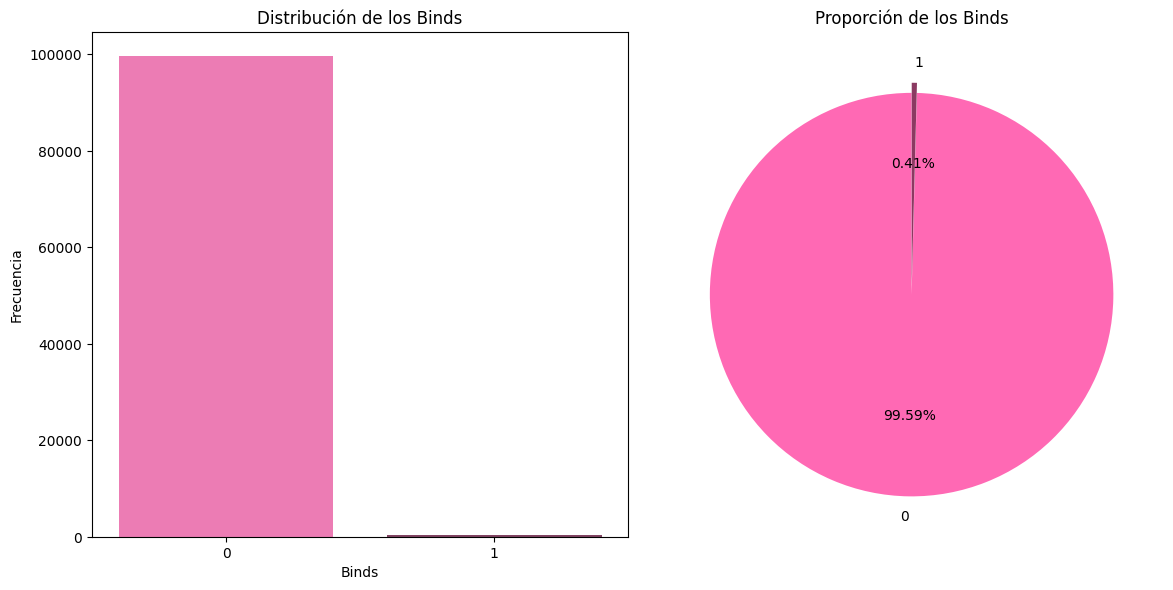

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.countplot(x = data_p3['binds'], hue = data_p3['binds'], palette = ['#FF69B4', '#8B3A62'], legend = False, ax=axes[0])
axes[0].set_title('Distribución de los Binds')
axes[0].set_xlabel('Binds')
axes[0].set_ylabel('Frecuencia')

binds3.plot(kind = 'pie', autopct = '%1.2f%%', colors = ['#FF69B4', '#8B3A62'], startangle = 90, explode = (0.05, 0), ax = axes[1])
axes[1].set_title('Proporción de los Binds')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()

 Se visualiza el desbalance de clases de manera clara, donde la clase **0** es mucho más frecuente que la clase **1**

Se utiliza `reset_index()` para reiniciar el índice del DataFrame `data_p2`

In [ ]:
data_p3 = data_p3.reset_index()

En esta parte se seleccionan las columnas categóricas (`protein_name`, `buildingblock1_smiles`, `buildingblock2_smiles`, `buildingblock3_smiles`) que contienen cadenas de texto, y se transforman en variables numéricas utilizando `OneHotEncoder`.

La codificación convierte estas columnas en variables binarias (0 o 1), donde cada valor único en una columna categórica se convierte en una nueva columna.

Finalmente, las nuevas columnas codificadas se añaden al DataFrame original y se eliminan las columnas categóricas originales.

In [ ]:
categoricas = ['protein_name', 'buildingblock1_smiles', 'buildingblock2_smiles', 'buildingblock3_smiles']
encoder3 = OneHotEncoder(sparse_output = False)
encoded3 = encoder3.fit_transform(data_p3[categoricas])
df_encoded3 = pd.DataFrame(encoded3, columns = encoder3.get_feature_names_out(categoricas))
df_proteina3 = pd.concat([data_p3, df_encoded3], axis = 1)
df_proteina3 = df_proteina3.drop(categoricas, axis = 1)

In [ ]:
df_proteina3.head()

,index,id,molecule_smiles,binds,protein_name_HSA,buildingblock1_smiles_C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21,buildingblock1_smiles_C#CC[C@@H](NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O,buildingblock1_smiles_C#CC[C@@](C)(NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O,buildingblock1_smiles_C#CC[C@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21,buildingblock1_smiles_C#CC[C@H](NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O,...,buildingblock3_smiles_Nc1ncnc(=O)[nH]1,buildingblock3_smiles_Nc1ncnc(Cl)c1Cl,buildingblock3_smiles_Nc1ncnc2[nH]cnc12,buildingblock3_smiles_Nc1ncnc2[nH]ncc12,buildingblock3_smiles_Nc1ncnc2c1ncn2C1CCCCO1,buildingblock3_smiles_Nc1ncncc1Br,buildingblock3_smiles_Nc1nnc(S)s1,buildingblock3_smiles_Nc1nncs1,buildingblock3_smiles_Nc1nnn[nH]1,buildingblock3_smiles_Nc1noc2ccc(F)cc12
0,79451005,79451005,N#Cc1cccc(Nc2nc(Nc3ccnc(Cl)c3)nc(NC3(C(=O)N[Dy...,0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,251510695,251510695,Cn1ncc2cc(Nc3nc(Nc4ccc(O)cn4)nc(N[C@@H](CC(=O)...,0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,50733376,50733376,Cc1cc(C(=O)N[Dy])ccc1Nc1nc(NCCOC2CCS(=O)(=O)C2...,0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,62661181,62661181,Cn1cc(C[C@@H](Nc2nc(NCC3CC(C(N)=O)=NO3)nc(Nc3c...,0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,266507149,266507149,Cc1ccnc(Nc2nc(Nc3ccc(O)cc3Cl)nc(N[C@H](CC(=O)N...,0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Las variables categóricas han sido correctamente transformadas en variables binarias (0 y 1).

In [ ]:
df_proteina3.shape

(100000, 1840)

Luego de haber codificado las variables categóricas, la base de datos cuenta con **100.000** filas y **1840** columnas

Verifiquemos que no se hayan generado datos faltantes con la codificación de las variables categóricas.

In [ ]:
missing_columns3 = df_proteina3.isnull().sum()
missing_columns3 = missing_columns3[missing_columns3 > 0]
print(f"Número de columnas con datos faltantes: {len(missing_columns3)}")

Número de columnas con datos faltantes: 0


En efecto, no hay datos faltantes.


En esta parte del código se eliminan las columnas `molecule_smiles` e `id`. Estas columnas no son necesarias para el modelo, ya que no aportan información relevante para la clasificación. La columna `molecule_smiles` es una cadena compleja que no es sencilla de codificar, dado la cantidad de registros únicos que esta variable presenta. Además, esta columna es una construcción de los tres bloques que ya fueron codificados, por lo que no aporta nueva información. Por otro lado, las columna `id` e `index` es simplemente un identificador de las observaciones y no tienen valor predictivo.

En esta parte del código, se lleva a cabo la selección de características y la definición de la variable objetivo

In [ ]:
df_proteina3.drop(columns = ['molecule_smiles'], inplace = True)
df_proteina3.drop(columns = ['id'], inplace = True)
df_proteina3.drop(columns = ['index'], inplace = True)

Se aplica SelectKBest con la función de chi-cuadrado (chi2) para seleccionar las 100 mejores características que tienen una relación más fuerte con la variable objetivo. Este proceso selecciona solo aquellas características que son más relevantes para la clasificación.

In [ ]:
y3 = df_proteina3['binds']

# Aplicar SelectKBest con chi2 para seleccionar las mejores características
k_best3 = SelectKBest(score_func = chi2, k = 100)  # Se quieren conservar k = 100 mejores características
X_new3 = k_best3.fit_transform(df_proteina3, y3)

selected_features = k_best3.get_support(indices=True)  # Obtener los índices de las características seleccionadas
proteina3 = df_proteina3.iloc[:, selected_features]

In [ ]:
proteina3.head()

,binds,buildingblock1_smiles_CC(C)(C)OC(=O)CCC(NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O,buildingblock1_smiles_CC(OC(C)(C)C)C(NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O,buildingblock1_smiles_Cc1cc(Cl)cc(C(=O)O)c1NC(=O)OCC1c2ccccc2-c2ccccc21,buildingblock1_smiles_Cc1ccc(C(=O)O)cc1NC(=O)OCC1c2ccccc2-c2ccccc21,buildingblock1_smiles_O=C(NC(CC1CCCCC1)C(=O)O)OCC1c2ccccc2-c2ccccc21,buildingblock1_smiles_O=C(NC(Cc1ccccc1)C(=O)O)OCC1c2ccccc2-c2ccccc21,buildingblock1_smiles_O=C(N[C@@H](Cc1cccnc1)C(=O)O)OCC1c2ccccc2-c2ccccc21,buildingblock1_smiles_O=C(N[C@H](Cc1ccc(-c2ccccc2)cc1)C(=O)O)OCC1c2ccccc2-c2ccccc21,buildingblock1_smiles_O=C(Nc1cc(C(=O)O)cc(C(=O)O)c1)OCC1c2ccccc2-c2ccccc21,...,buildingblock3_smiles_Nc1cccc2ocnc12,buildingblock3_smiles_Nc1cn[nH]c1,buildingblock3_smiles_Nc1cncc(F)c1,buildingblock3_smiles_Nc1n[nH]c2cc(F)ccc12,buildingblock3_smiles_Nc1nc(Cl)c2[nH]cnc2n1,buildingblock3_smiles_Nc1nc2c(s1)CN(C(=O)OCc1ccccc1)CC2,buildingblock3_smiles_Nc1nc[nH]n1,buildingblock3_smiles_Nc1ncnc(Cl)c1Cl,buildingblock3_smiles_Nc1nncs1,buildingblock3_smiles_Nc1nnn[nH]1
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
proteina3.shape

(100000, 100)

Finalmente, la base de datos `proteina3` esta lista para ser usada en los diferentes modelos de clasificación. Esta base de datos cuenta con **100.000** filas y **100** columnas

# **Ejercicio 2.2: Single-Cell Perturbations**

## **Contextualización**

### **Objetivos**

El objetivo es predecir cómo las moléculas pequeñas alteran la expresión génica en diferentes tipos de células, lo que podría acelerar el descubrimiento de fármacos. La biología humana es compleja, con billones de células organizadas en tejidos y órganos. Las tecnologías unicelulares permiten estudiar el ADN, ARN y proteínas a este nivel, pero los experimentos son costosos y no todos los tejidos pueden ser analizados eficientemente.

Existen métodos como Dr.VAE, scGEN y ChemCPA para predecir perturbaciones de fármacos, pero carecen de datos suficientes y diversos. El mayor conjunto de datos, CMap, tiene información limitada, cubriendo solo el 5% de los genes, mayormente en líneas celulares cancerosas. Con este trabajo se busca mejorar la predicción de perturbaciones en diferentes tipos de células para ayudar en la creación de nuevos medicamentos más eficaces.


<div style="text-align: center;">
    <img src="https://github.com/kmarcela11/Parcial1_MachineLearning/blob/main/imagen2.jpg?raw=true" alt= " " width="600"/>
</div>



### **Descripción de la base de datos**

Este conjunto de datos se creó usando células de sangre de tres donantes humanos sanos, tratadas con 144 compuestos. Después de 24 horas, se midió la actividad génica de diferentes tipos de células inmunes (T y B) para identificar genes sensibles a los tratamientos.

Las células se colocaron en placas de 96 pocillos, con controles positivos y negativos, y unos 350 células por pocillo. Debido a la toxicidad de algunos compuestos, no siempre se observaron todos los tipos de células.

Para la secuenciación, se utilizó Multiplexación Celular, que introduce sesgo técnico corregido mediante controles. La expresión diferencial se calculó agrupando recuentos por tipo de célula y ajustando un modelo lineal con Limma, considerando covariables como la placa, el donante y el compuesto.

Dado que nuestro enfoque sera entrenar un modelo que busque predecir como os compuestos afectan la expresión génica en diferentes tipos de células, solo se hará uso de las bases de datos `de_train`, `adata_train`y `adata_obs_meta`. Las otras bases de datos (`multiome_train` y `multiome_var_meta`) serán omitidas para este trabajo dado que estos archivos contienen datos sobre accesibilidad a la cromatina y mediciones multi-ormicas adicionales y nuestro enfoque es diferente.

## **Base 1: de_train**

Esta base de datos contiene datos agregados de expresión diferencial de **18,211** genes. Cada gen tiene un valor de cambio logarítmico (LFC), que mide cuánto cambia su expresión en respuesta a los compuestos en comparación con el control (DMSO).

Este archivo contiene los datos clave, con valores agregados de expresión diferencial para diversas combinaciones de tipos de células y nombres de compuestos. Estos datos muestran cómo varía la expresión génica bajo condiciones de tratamiento en comparación con el control.

#### **Diccionario de variables**

| **Variable**  | **Descripción**                                                                                                                                                                             |
|---------------|---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **genes**     | A1BG, A1BG-AS1, …, ZZEF1 (total: 18,211 genes). Valor de expresión diferencial (-log10(p-value) * signo(LFC)) para cada gen. **LFC** es el cambio logarítmico estimado en la expresión entre la condición de tratamiento y control. Un LFC positivo indica un aumento del gen en la condición de tratamiento. |
| **cell_type** | Tipo de célula anotado, basado en la expresión de ARN de cada célula.                                                                                                                        |
| **sm_name**   | Nombre principal del compuesto (padre), en una representación estandarizada seleccionada por LINCS. Se utiliza para mapear los datos del experimento al Mapa de Conectividad de LINCS.         |
| **sm_lincs_id** | ID global de LINCS del compuesto (padre), en una representación estandarizada. Se utiliza para mapear los datos del experimento al Mapa de Conectividad de LINCS.                            |
| **SMILES**    | Representación del sistema de entrada simplificado de línea de entrada molecular (SMILES) de los compuestos utilizados. Es una representación en 1D de la estructura molecular.                |
| **control**   | Booleano que indica si esta instancia se utilizó como control.                                                                                                                               |


### **Base de datos**

Inicialmente se hace el cargue del conjunto de datos de entrenamiento, con el uso de la librería `pandas` y el módulo **`read_parquet`** para leer el archivo en formato `Parquet`.

In [73]:
# de_train = pd.read_parquet('de_train.parquet')
de_train = pd.read_parquet('C:/Users/kamac/OneDrive/Desktop/MachineLearningUN/de_train.parquet')

### **Características de la base de datos**

Ahora, se hace uso del método `head()` para visualizar las primeras 5 observaciones de la base de datos

In [9]:
de_train.head()

,cell_type,sm_name,sm_lincs_id,SMILES,control,A1BG,A1BG-AS1,A2M,A2M-AS1,A2MP1,...,ZUP1,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1
0,NK cells,Clotrimazole,LSM-5341,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,False,0.104720,-0.077524,-1.625596,-0.144545,0.143555,...,-0.227781,-0.010752,-0.023881,0.674536,-0.453068,0.005164,-0.094959,0.034127,0.221377,0.368755
1,T cells CD4+,Clotrimazole,LSM-5341,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,False,0.915953,-0.884380,0.371834,-0.081677,-0.498266,...,-0.494985,-0.303419,0.304955,-0.333905,-0.315516,-0.369626,-0.095079,0.704780,1.096702,-0.869887
2,T cells CD8+,Clotrimazole,LSM-5341,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,False,-0.387721,-0.305378,0.567777,0.303895,-0.022653,...,-0.119422,-0.033608,-0.153123,0.183597,-0.555678,-1.494789,-0.213550,0.415768,0.078439,-0.259365
3,T regulatory cells,Clotrimazole,LSM-5341,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,False,0.232893,0.129029,0.336897,0.486946,0.767661,...,0.451679,0.704643,0.015468,-0.103868,0.865027,0.189114,0.224700,-0.048233,0.216139,-0.085024
4,NK cells,Mometasone Furoate,LSM-3349,C[C@@H]1C[C@H]2[C@@H]3CCC4=CC(=O)C=C[C@]4(C)[C...,False,4.290652,-0.063864,-0.017443,-0.541154,0.570982,...,0.758474,0.510762,0.607401,-0.123059,0.214366,0.487838,-0.819775,0.112365,-0.122193,0.676629


Con el uso del método `info()` y `shape` se puede observar una visión general de las características de la base de datos.

In [10]:
de_train.shape

(614, 18216)

In [11]:
de_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Columns: 18216 entries, cell_type to ZZEF1
dtypes: bool(1), float64(18211), object(4)
memory usage: 85.3+ MB


Este conjunto de datos contiene **614** filas y **18216** columnas

### **Datos Faltantes**

El método `de_train.isnull().sum().sort_values(ascending=False)` se utiliza para identificar y contar los valores nulos en cada columna del DataFrame **de_train**.

In [12]:
de_train.isnull().sum().sort_values(ascending = False)

,0
ZZEF1,0
cell_type,0
sm_name,0
sm_lincs_id,0
SMILES,0
...,...
AAAS,0
AACS,0
AAGAB,0
AAK1,0


En este caso, el resultado muestra que no hay valores nulos en ninguna columna, ya que todas tienen un recuento de 0, lo que indica que los datos están completos.

### **Variables categóricas**

In [13]:
de_train.describe(include = 'object')

,cell_type,sm_name,sm_lincs_id,SMILES
count,614,614,614,614
unique,6,146,146,146
top,NK cells,Penfluridol,LSM-2334,OC1(c2ccc(Cl)c(C(F)(F)F)c2)CCN(CCCC(c2ccc(F)cc...
freq,146,6,6,6


Con el uso del método `.describe(include='object')`, se generó un resumen de las columnas categóricas de los datos **de_train**. El análisis muestra que hay 614 observaciones en las columnas **cell_type**, **sm_name**, **sm_lincs_id**, y **SMILES**. Existen 6 tipos de células únicos, 146 compuestos únicos, y 146 representaciones moleculares SMILES. El tipo de célula más frecuente es **NK cells** con 146 observaciones, mientras que el compuesto más común es **R428** con 6 ocurrencias.


#### **Variable categórica: Cell_type**



Ahora se utiliza el método `de_train['cell_type'].value_counts()` para contar la cantidad de veces que aparece cada tipo de célula en el DataFrame **de_train**.


In [14]:
de_train['cell_type'].value_counts()

,count
cell_type,
NK cells,146
T cells CD4+,146
T regulatory cells,146
T cells CD8+,142
B cells,17
Myeloid cells,17


- **Células NK**: Destruyen rápidamente células infectadas y cancerosas
sin necesidad de activación previa, siendo clave en la respuesta inmune innata.
- **Células T CD4+**: Coordinan la respuesta inmune activando otras células, como las células B, regulando la defensa adaptativa.
- **Células T reguladora**s: Mantienen el equilibrio inmune, previniendo respuestas autoinmunes y limitando inflamaciones excesivas.
- **Células T CD8+**: Eliminan específicamente células infectadas o cancerosas mediante la liberación de moléculas que inducen la muerte celular.
- **Células B**: Producen anticuerpos y son responsables de la memoria inmunológica, protegiendo contra infecciones futuras.
- **Células mieloides**: Incluyen macrófagos que fagocitan patógenos y células dendríticas que inician la respuesta inmune presentando antígenos.

Viendolo gráficamente

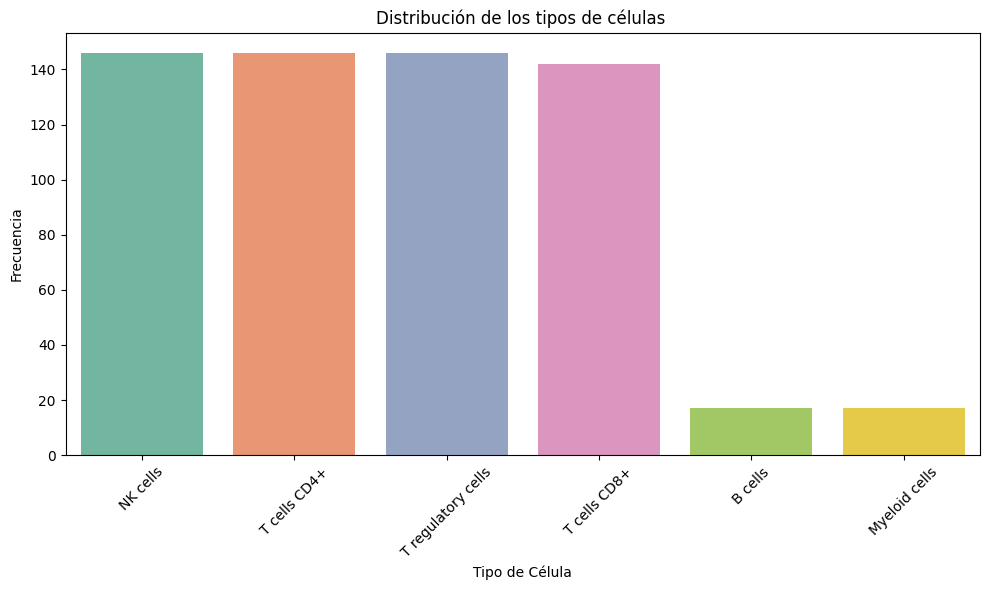

In [15]:
cell_type_counts = de_train['cell_type'].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x = cell_type_counts.index, y = cell_type_counts.values, hue = cell_type_counts.index, dodge = False, palette = "Set2", legend = False)
plt.title('Distribución de los tipos de células ')
plt.xlabel('Tipo de Célula')
plt.ylabel('Frecuencia')
plt.xticks(rotation = 45)
plt.tight_layout()
plt.show()


En este caso, el resultado muestra que las células NK, T cells CD4+ y T regulatory cells son las más frecuentes con 146 observaciones cada una, mientras que las células B y Myeloid tienen solo 17 observaciones cada una.

#### **Variable categórica: sm_name**



Ahora se utiliza el método `de_train['sm_name'].value_counts()` para contar la cantidad de veces que aparece cada tipo de mólecula (compuesto) en el DataFrame **de_train**.

In [16]:
de_train['sm_name'].value_counts()

,count
sm_name,
Penfluridol,6
Dabrafenib,6
O-Demethylated Adapalene,6
Palbociclib,6
Porcn Inhibitor III,6
...,...
Prednisolone,4
Tamatinib,4
CC-401,4


Nótese que hay 146 tipos de compuestos donde la frecuencia varia desde **Penfluridol** con 6 observaciones hasta **Resminostat** con 3 observaciones

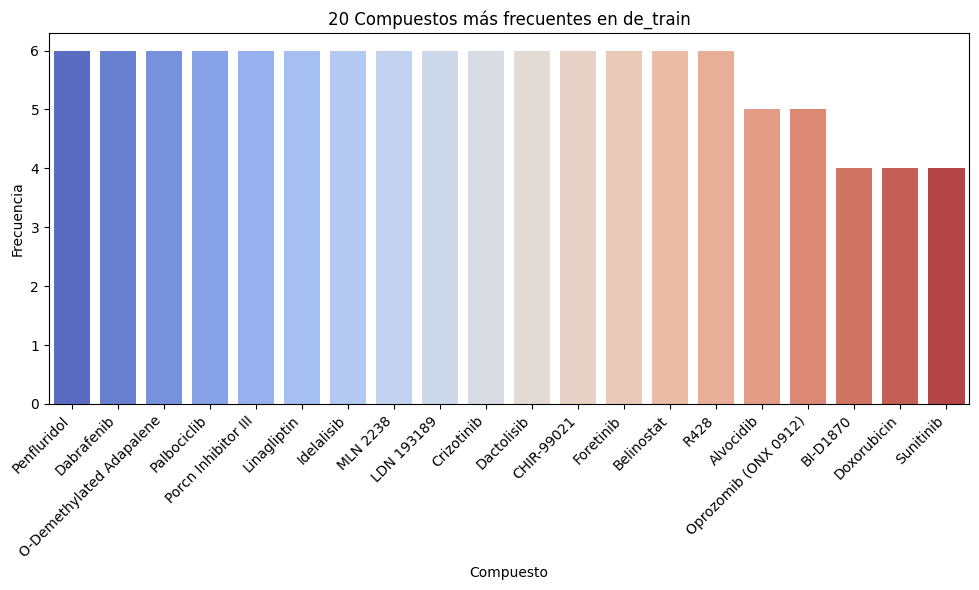

In [17]:
compound_counts = de_train['sm_name'].value_counts()
# Limitar el gráfico a los 20 compuestos más frecuentes
top_compounds = compound_counts.head(20)
plt.figure(figsize=(10, 6))
sns.barplot(x = top_compounds.index, y = top_compounds.values,hue = top_compounds.index, palette = "coolwarm")
plt.title('20 Compuestos más frecuentes en de_train')
plt.xlabel('Compuesto')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


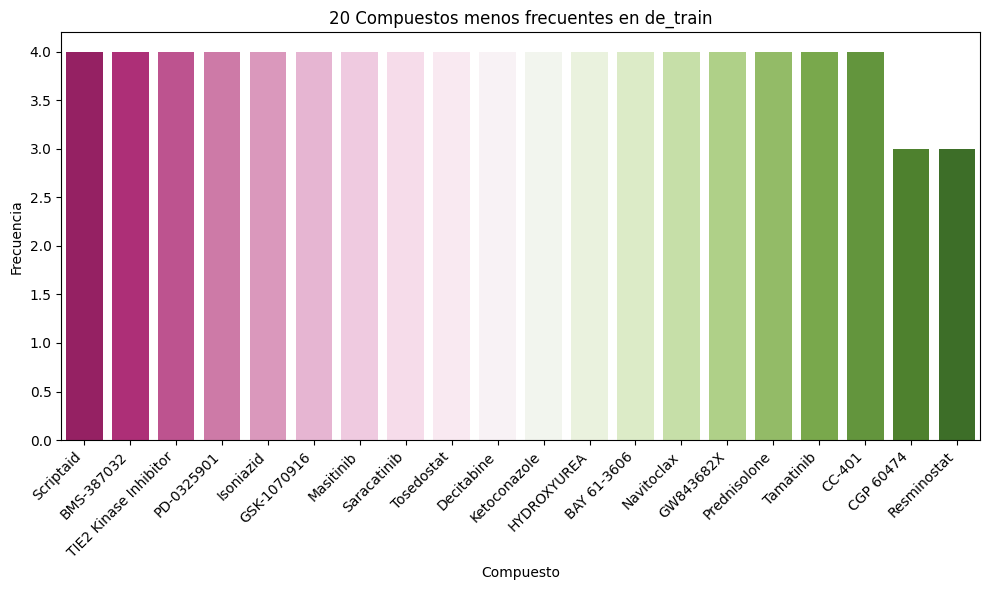

In [18]:
# Limitar el gráfico a los 20 compuestos menos frecuentes
tail_compounds = compound_counts.tail(20)
plt.figure(figsize=(10, 6))
sns.barplot(x = tail_compounds.index, y = tail_compounds.values,hue = tail_compounds.index, palette = "PiYG")
plt.title('20 Compuestos menos frecuentes en de_train')
plt.xlabel('Compuesto')
plt.ylabel('Frecuencia')
plt.xticks(rotation = 45, ha = 'right')
plt.tight_layout()
plt.show()

Las dos gráficas muestran la distribución de los compuestos más y menos frecuentes en el conjunto de datos **de_train**. En la primera gráfica, observamos los 20 compuestos más comunes, con una frecuencia máxima de 6 apariciones para compuestos como **R428**, **MLN 2238**, **Dactolisib**, y otros. Estos compuestos son los más utilizados en el experimento, posiblemente por su relevancia o por su efecto sobre la expresión génica. En la segunda gráfica, se presentan los 20 compuestos menos frecuentes, con una frecuencia de 4 para todos ellos. Estos compuestos, como **RN-486**, **AZD-8330**, y **Prednisolone**, se utilizan con menos regularidad en el experimento.


#### **Variable categórica: sm_lincs_id**

In [19]:
de_train['sm_lincs_id'].value_counts()

,count
sm_lincs_id,
LSM-2334,6
LSM-6303,6
LSM-6237,6
LSM-1071,6
LSM-47425,6
...,...
LSM-24954,4
LSM-1040,4
LSM-1186,4


Esta variable está muy relacionada con la anterior ya que representa el ID global de LINCS del compuesto. Por lo tanto hay 146 valores únicos correspondientes a los 146 compuestos que hay. Aparecen con la misma frecuencia

#### **Variable categórica: SMILES**

En esta parte se hará la representación gráfica de 6 de los compuestos utilizados en la base. Es una representación en 1D de la estructura molecular.

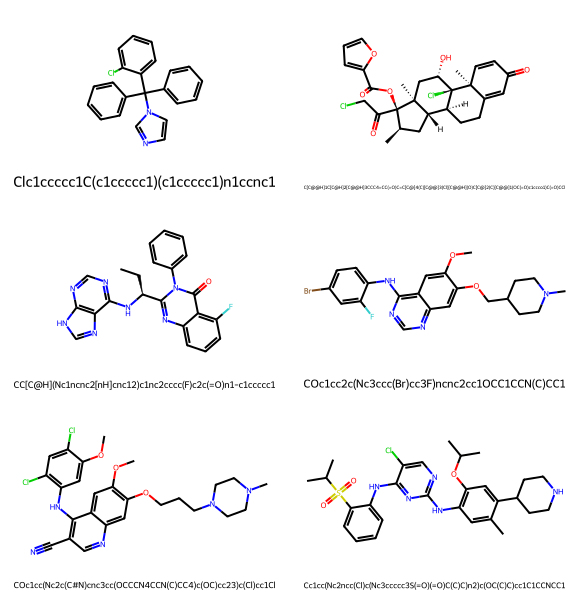

In [20]:
smiles = de_train['SMILES'].unique()[:6] # Extrae las estructuras SMILES únicas
moleculas = [Chem.MolFromSmiles(smiles) for smiles in smiles] # Convertir SMILES a objetos Mol
legends = [smiles for smiles in smiles] # Leyendas de las moleculas
img = Draw.MolsToGridImage(moleculas, molsPerRow = 2, subImgSize = (290, 200), legends = legends) # Genera la imagen
display(img) # muestra la imagen

#### **Variable categórica: Control**

Booleano que indica si esa observación se utilizó como control.

In [21]:
de_train['control'].value_counts()

,count
control,
False,602
True,12


Nótese que se tomaron 12 observaciones como control y 602 no se tuvieron en cuenta para esto.

In [22]:
de_train.groupby(['control', 'cell_type']).size()

control  cell_type         
False    B cells                15
         Myeloid cells          15
         NK cells              144
         T cells CD4+          144
         T cells CD8+          140
         T regulatory cells    144
True     B cells                 2
         Myeloid cells           2
         NK cells                2
         T cells CD4+            2
         T cells CD8+            2
         T regulatory cells      2
dtype: int64

Podemos afirmar que se tomaron 2 observaciones como control para cada tipo de célula.

### **Variables numéricas**

In [23]:
de_train.describe()

,A1BG,A1BG-AS1,A2M,A2M-AS1,A2MP1,A4GALT,AAAS,AACS,AAGAB,AAK1,...,ZUP1,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1
count,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,...,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000
mean,0.366769,0.250951,0.148259,0.155733,0.684275,0.946273,0.000582,0.348203,0.009424,0.062662,...,0.071179,0.159252,0.018584,0.267114,0.497043,0.382672,0.240726,0.161087,-0.160735,-0.071255
std,1.634697,1.188660,2.275410,2.184095,3.189206,3.826391,0.703410,1.259422,0.952243,1.237806,...,1.028842,1.128245,1.333236,1.439952,1.691722,1.430553,0.918039,0.779918,0.932961,0.748377
min,-3.258689,-4.067518,-28.552191,-17.801989,-6.378904,-6.908058,-3.167504,-2.825505,-3.654218,-8.042101,...,-4.309438,-4.276411,-21.273505,-5.520507,-6.780020,-2.617712,-8.310726,-3.456731,-7.189487,-4.819105
25%,-0.215161,-0.267728,-0.230129,-0.229460,-0.190989,-0.123963,-0.261792,-0.197019,-0.356774,-0.214164,...,-0.349490,-0.289498,-0.421265,-0.275030,-0.119912,-0.135779,-0.141982,-0.169364,-0.479099,-0.402733
50%,0.082722,0.102076,0.044717,0.036156,0.116411,0.131515,0.009045,0.144223,-0.028306,0.068134,...,0.010186,0.063539,-0.010158,0.065780,0.148876,0.145279,0.137559,0.062804,-0.083260,-0.058601
75%,0.528015,0.523162,0.405858,0.532216,0.616725,0.580870,0.268029,0.560221,0.253911,0.413308,...,0.330117,0.479763,0.361876,0.482989,0.683587,0.600652,0.510566,0.487592,0.266170,0.252387
max,22.085428,14.421991,27.557166,27.603715,35.278040,34.785942,5.079223,15.589494,10.855080,6.518868,...,10.803264,15.959706,10.649018,17.231287,23.721492,23.089832,10.844942,4.822008,7.826692,3.534737


Con el uso del método `.describe()`, se generó un resumen de las columnas numéricas de los datos **de_train**. El análisis muestra que hay 614 observaciones de cada tipo de gen y muestra las diferentes distribuciones que estos presentan a través de los datos.

Nótese que hay **18211** variables numéricas, las cuales corresponden a los valores de expresión diferencial de cada gen. Dado la dimension de estas variables se realizará un resumen general de estas.

El siguiente análisis se realiza sobre el subconjunto de datos extraídos de **`de_train`** entre las columnas 5 en adelante, usando el método `.iloc`. Esto para seleccionar todas las variables numéricas de este conjunto de datos.  

In [24]:
genes  = de_train.iloc[:,5:]

A continuación, se presentan los 5 genes con los valores promedio más altos en su expresión diferencial, clasificados en orden descendente.


In [25]:
genes.mean().sort_values(ascending = False).head()

,0
ZFAS1,1.801987
SNHG6,1.496899
BBC3,1.484452
RPS19,1.450786
HIST1H1B,1.366936


En este caso, los genes A2MP1 y A4GALT son los que presentan los valores promedios más altos en términos de expresión diferencial.

Ahora, se presentan los 5 genes con los valores promedio menos altos en su expresión diferencial, clasificados en orden descendente.

In [26]:
genes.mean().sort_values(ascending = False).tail()

,0
EMP3,-2.063746
S100A6,-2.186575
HCST,-2.353166
CORO1A,-2.432830
ACTB,-2.496158


Los genes AAK1 y AAAS muestran los valores promedios más bajos dentro de este subconjunto de datos.

#### **Análisis de simetría**

En esta sección, se visualizará la distribución de los datos utilizando un boxplot. Este tipo de gráfico es ideal porque permite resumir de manera concisa la distribución de los datos, mostrando la mediana, los cuartiles y la presencia de valores atípicos. Además, facilita la identificación de posibles asimetrías o dispersión en los datos.

Se presentarán boxplots tanto para los primeros 15 genes como para los últimos 15 genes, mostrando la distribución de la expresión diferencial.

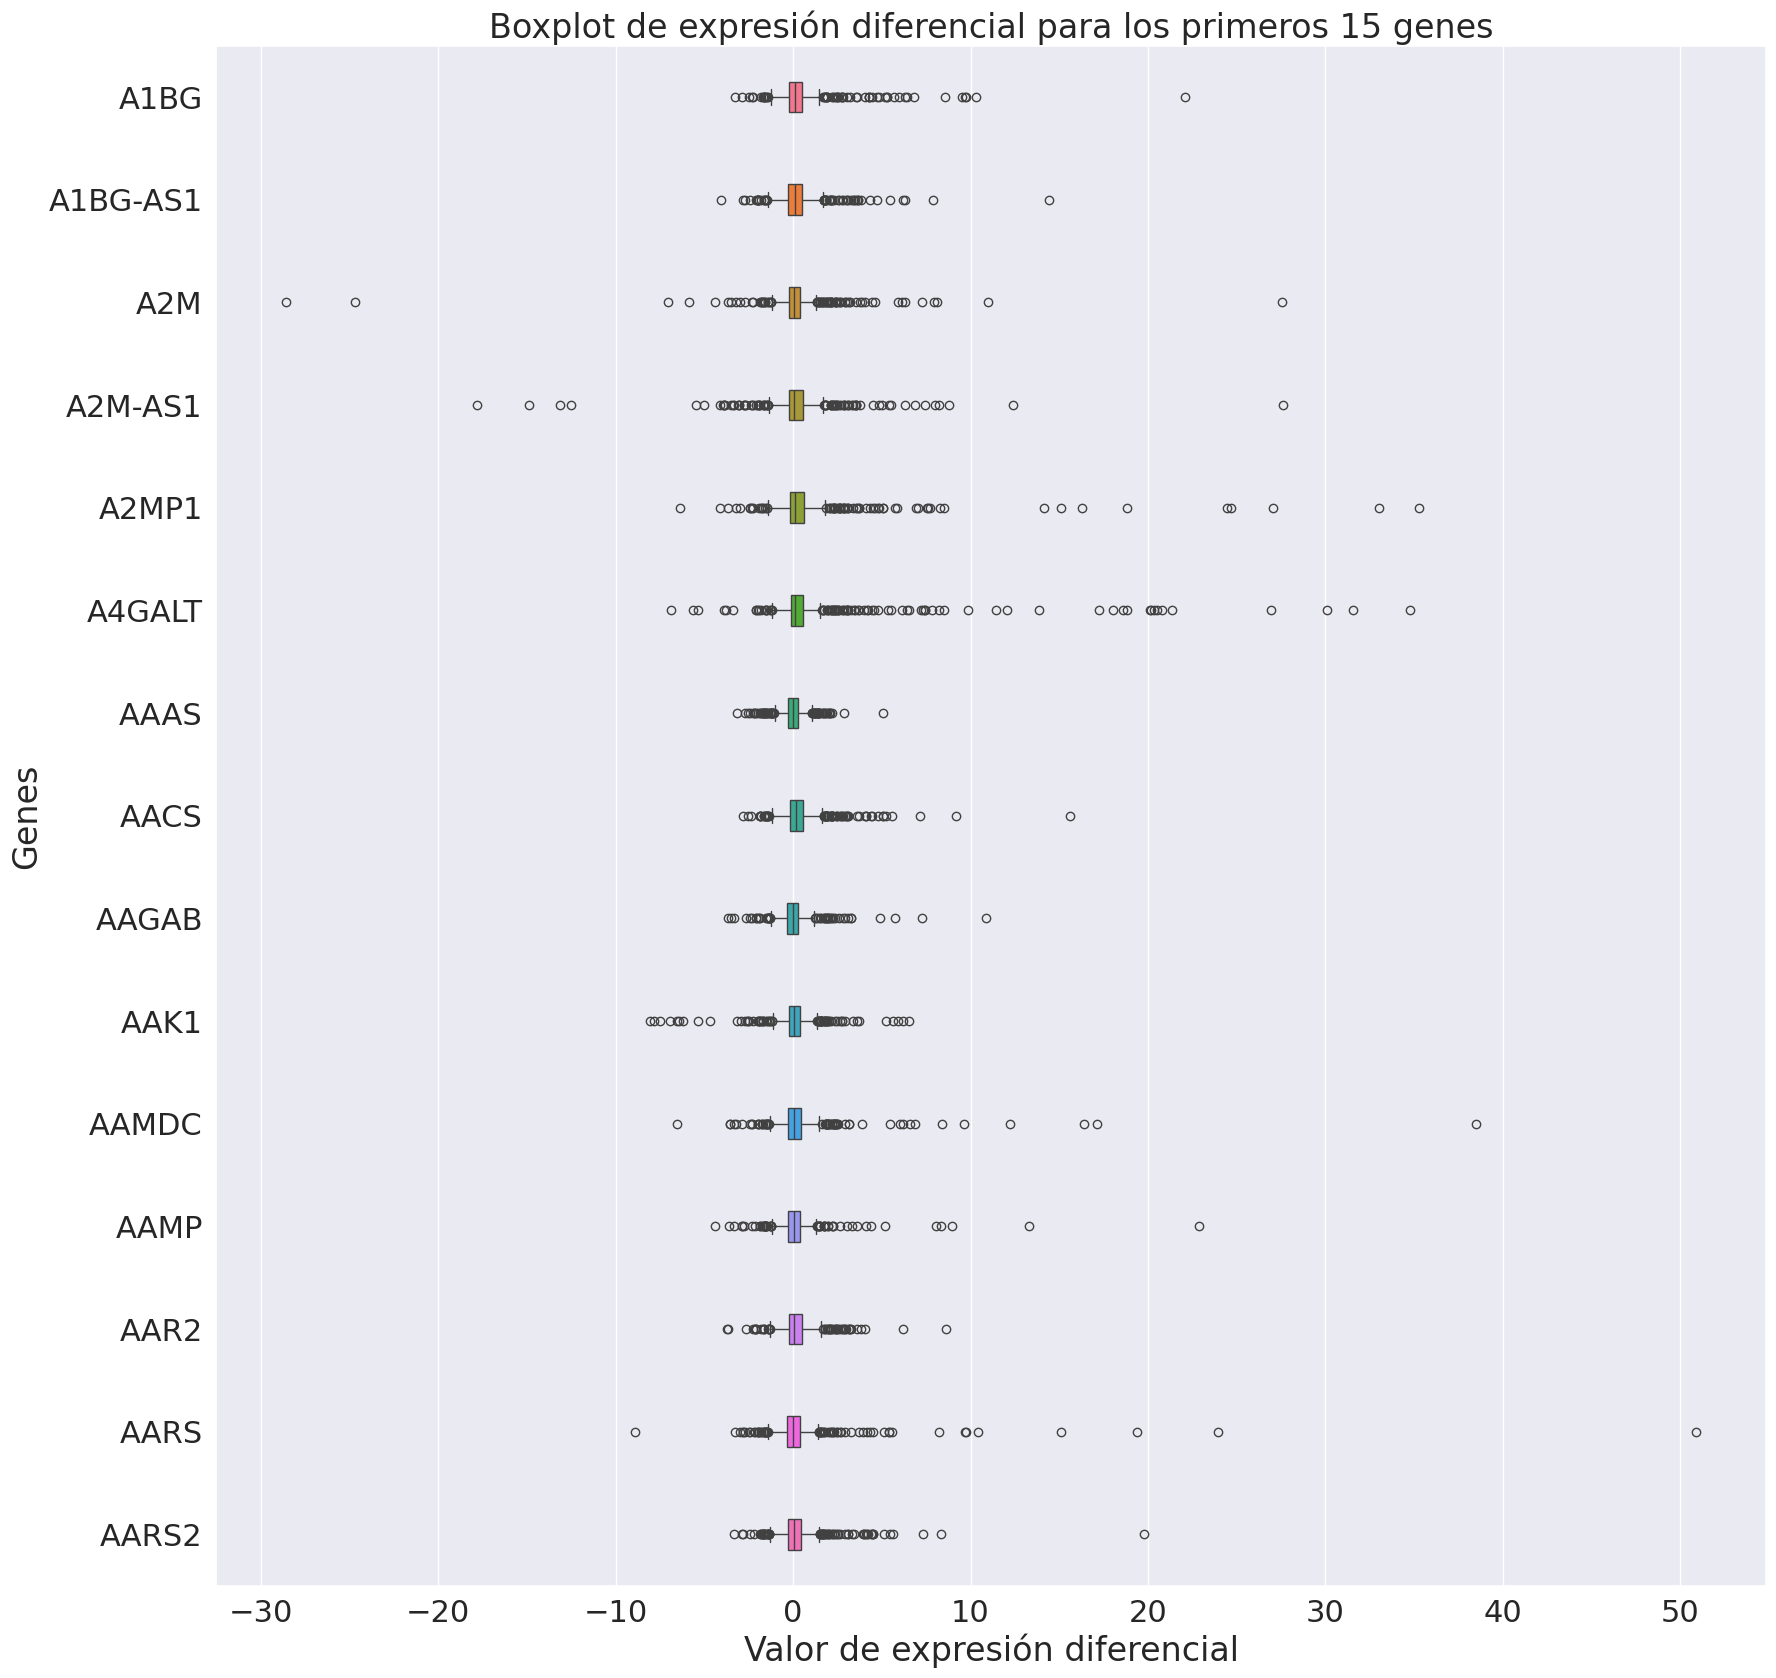

In [27]:
genes = de_train.iloc[:, 5:20]
sns.set(font_scale = 2)
plt.figure(figsize = (20, 20))
sns.boxplot(data=genes, width=0.3, saturation=0.9, orient = "h")
plt.title('Boxplot de expresión diferencial para los primeros 15 genes')
plt.xlabel('Valor de expresión diferencial')
plt.ylabel('Genes')
plt.show()



Este primer gráfico, muestra la distribución de la expresión diferencial para los primeros 15 genes, se puede observar que la mayoría de los genes tienen valores de expresión concentrados alrededor de cero, lo que indica que no presentan cambios significativos bajo las condiciones estudiadas. Sin embargo, algunos genes, como AARS y A4GALT, presentan valores atípicos que se alejan mucho de los límites del boxplot, es decir, en ciertos experimentos, estos genes experimentan variaciones notables en su expresión.

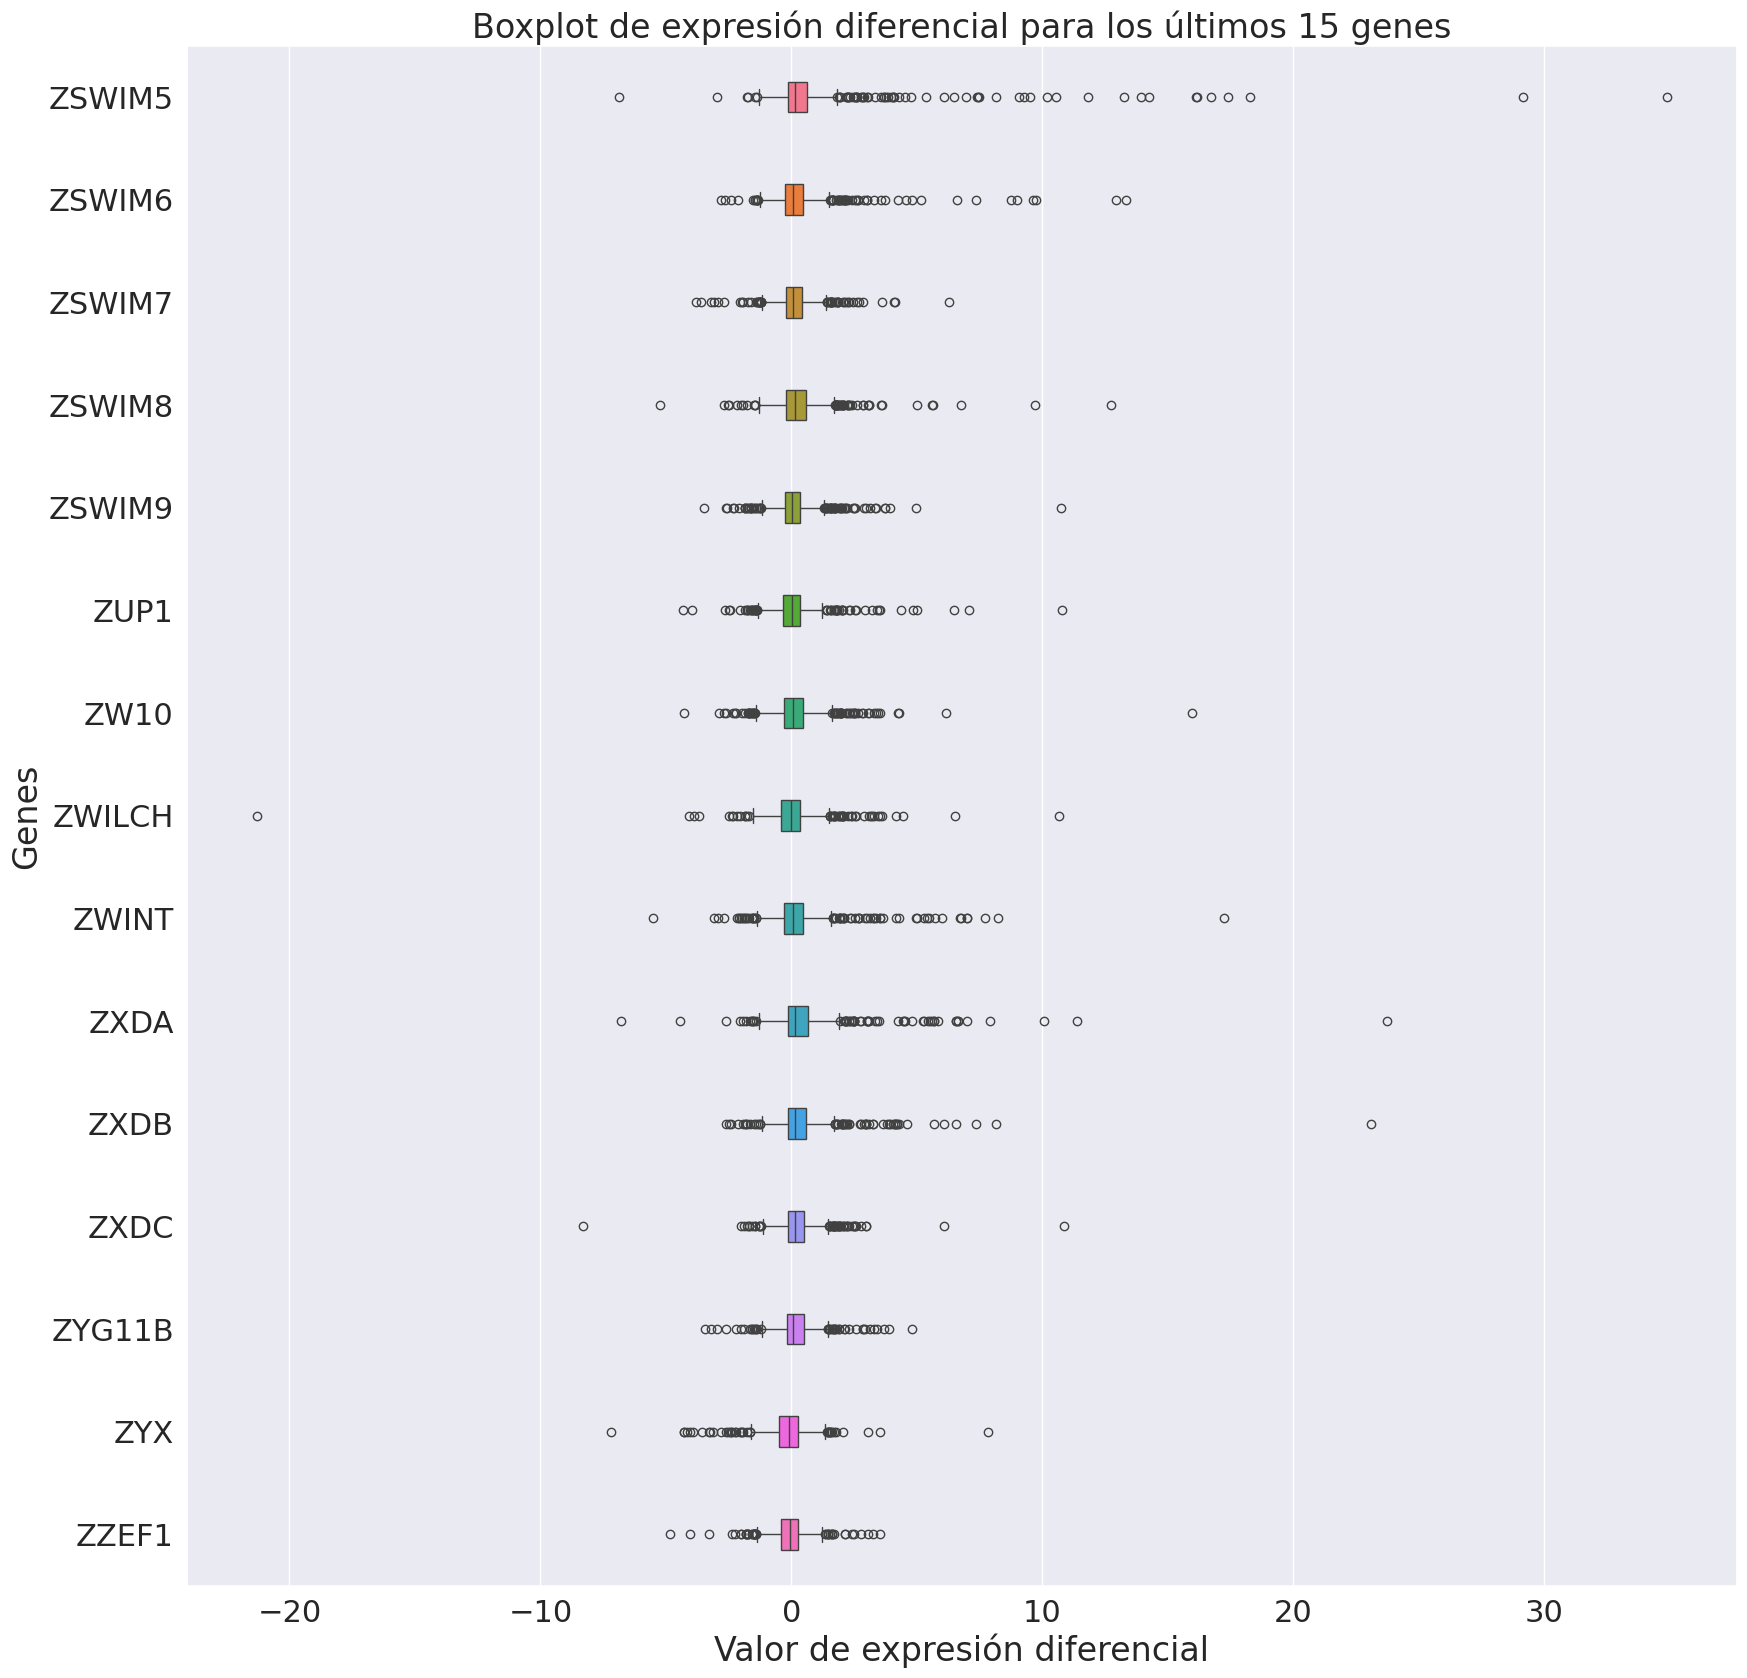

In [28]:
genes = de_train.iloc[:, 18201:18216]
sns.set(font_scale = 2)
plt.figure(figsize = (20, 20))
sns.boxplot(data=genes, width=0.3, saturation=0.9, orient = "h")
plt.title('Boxplot de expresión diferencial para los últimos 15 genes')
plt.xlabel('Valor de expresión diferencial')
plt.ylabel('Genes')
plt.show()

En seste segundo gráfico, que representa los últimos 15 genes, la mayoría de los genes también muestran una concentración de valores cerca de cero, con poca dispersión y sin grandes variaciones en su expresión diferencial. Sin embargo, algunos genes como ZZEF1 y ZSWIM5 destacan debido a la presencia de valores atípicos notables que se alejan del rango intercuartílico.

Conclusión: Al observar ambas gráficas donde se representan los valores de expresión diferencial para los primeros 15 y últimos 15 genes es correcto afirmar la existencia de datos atípicos en la mayoría de los genes.

##### **Imputación de datos atípicos**

Inicialmente veamos el supuesto de normalidad.

In [86]:
columnas_normales = []
atipicos = de_train.iloc[:, 5:]

for columna in atipicos.columns:
    estadistico_ks, p_value = kstest(atipicos[columna], 'norm', args=(atipicos[columna].mean(), atipicos[columna].std()))

    # Si el valor p es mayor a 0.05, no podemos rechazar la hipótesis nula (distribución normal)
    if p_value > 0.05:
        columnas_normales.append(columna)

print(f"Columnas que se distribuyen normalmente: {columnas_normales}")
print(f"Número de columnas que se distribuyen normalmente: {len(columnas_normales)}")


Columnas que se distribuyen normalmente: []
Número de columnas que se distribuyen normalmente: 0


Nótese que ninguna columna presenta una distribución normal, por lo tanto se usará la mediana para la imputación de los datos atípicos.

Para la imputación de datos atípicos se usará la mediana debido a su robustez frente a valores extremos. El uso de la mediana para la imputación también ayuda a prevenir el sobreajuste en modelos predictivos más adelante. Al reemplazar los valores atípicos con la mediana, se evita introducir sesgos en el conjunto de datos, lo que asegura que el modelo no se ajuste demasiado a los valores extremos, que pueden no ser representativos de la verdadera distribución de los datos.

In [29]:
def replace_outliers(col):
    Q1 = col.quantile(0.25)
    Q3 = col.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    median_value = col.median()
    return col.where((col >= lower_bound) & (col <= upper_bound), median_value)

df_de_train = de_train.iloc[:, 5:].apply(replace_outliers)

In [30]:
df_de_train.describe()

,A1BG,A1BG-AS1,A2M,A2M-AS1,A2MP1,A4GALT,AAAS,AACS,AAGAB,AAK1,...,ZUP1,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1
count,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,...,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000
mean,0.088363,0.111249,0.037877,0.087270,0.129633,0.127454,0.010001,0.150489,-0.056577,0.080360,...,-0.015463,0.060479,-0.056368,0.058255,0.198583,0.165752,0.152593,0.116508,-0.098306,-0.058010
std,0.500687,0.537476,0.430133,0.501572,0.546298,0.460569,0.376397,0.525669,0.438410,0.428630,...,0.476573,0.535390,0.543998,0.519351,0.537817,0.516135,0.471284,0.493701,0.539453,0.490965
min,-1.270048,-1.424666,-1.166581,-1.367801,-1.389629,-1.166084,-1.024258,-1.178222,-1.272353,-1.126649,...,-1.332876,-1.415372,-1.517931,-1.363628,-1.304153,-1.166314,-1.117706,-1.152181,-1.590996,-1.365706
25%,-0.177102,-0.190342,-0.168035,-0.144079,-0.149290,-0.089972,-0.172332,-0.142739,-0.290951,-0.130912,...,-0.253441,-0.199999,-0.354655,-0.180747,-0.093180,-0.104605,-0.108308,-0.142971,-0.370305,-0.334123
50%,0.082722,0.102076,0.044717,0.036156,0.116411,0.131515,0.009045,0.144223,-0.028306,0.068134,...,0.010186,0.063539,-0.010158,0.065780,0.148876,0.145279,0.137559,0.062804,-0.083260,-0.058601
75%,0.341912,0.387859,0.232044,0.308295,0.386306,0.314136,0.187794,0.368456,0.178025,0.291710,...,0.229929,0.319802,0.257794,0.328312,0.438525,0.385152,0.372393,0.397249,0.226954,0.212230
max,1.438209,1.705225,1.309304,1.664625,1.783968,1.522304,1.049887,1.645047,1.165461,1.323083,...,1.232428,1.630143,1.488695,1.593819,1.884693,1.705294,1.454256,1.451861,1.333133,1.218371


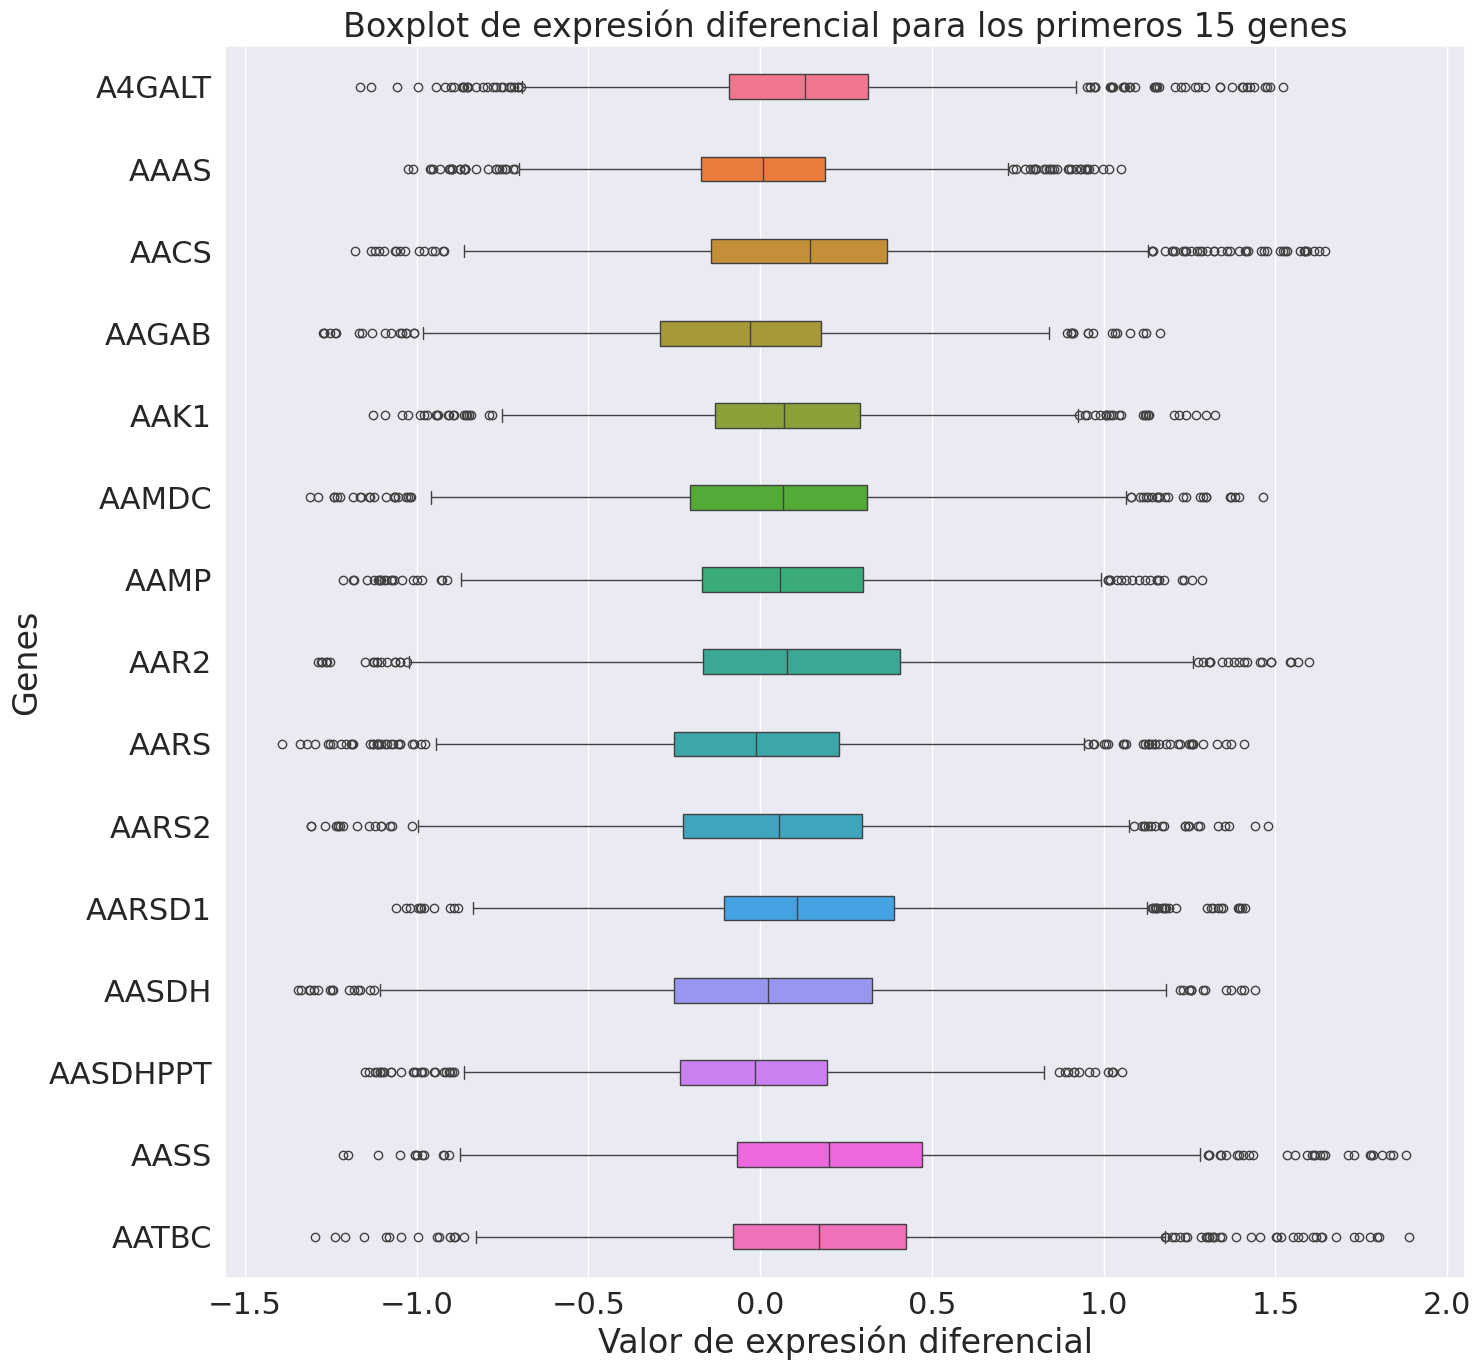

In [31]:
genes = df_de_train.iloc[:, 5:20]
sns.set(font_scale = 2)
plt.figure(figsize = (16, 16))
sns.boxplot(data=genes, width=0.3, saturation=0.9, orient = "h")
plt.title('Boxplot de expresión diferencial para los primeros 15 genes')
plt.xlabel('Valor de expresión diferencial')
plt.ylabel('Genes')
plt.show()


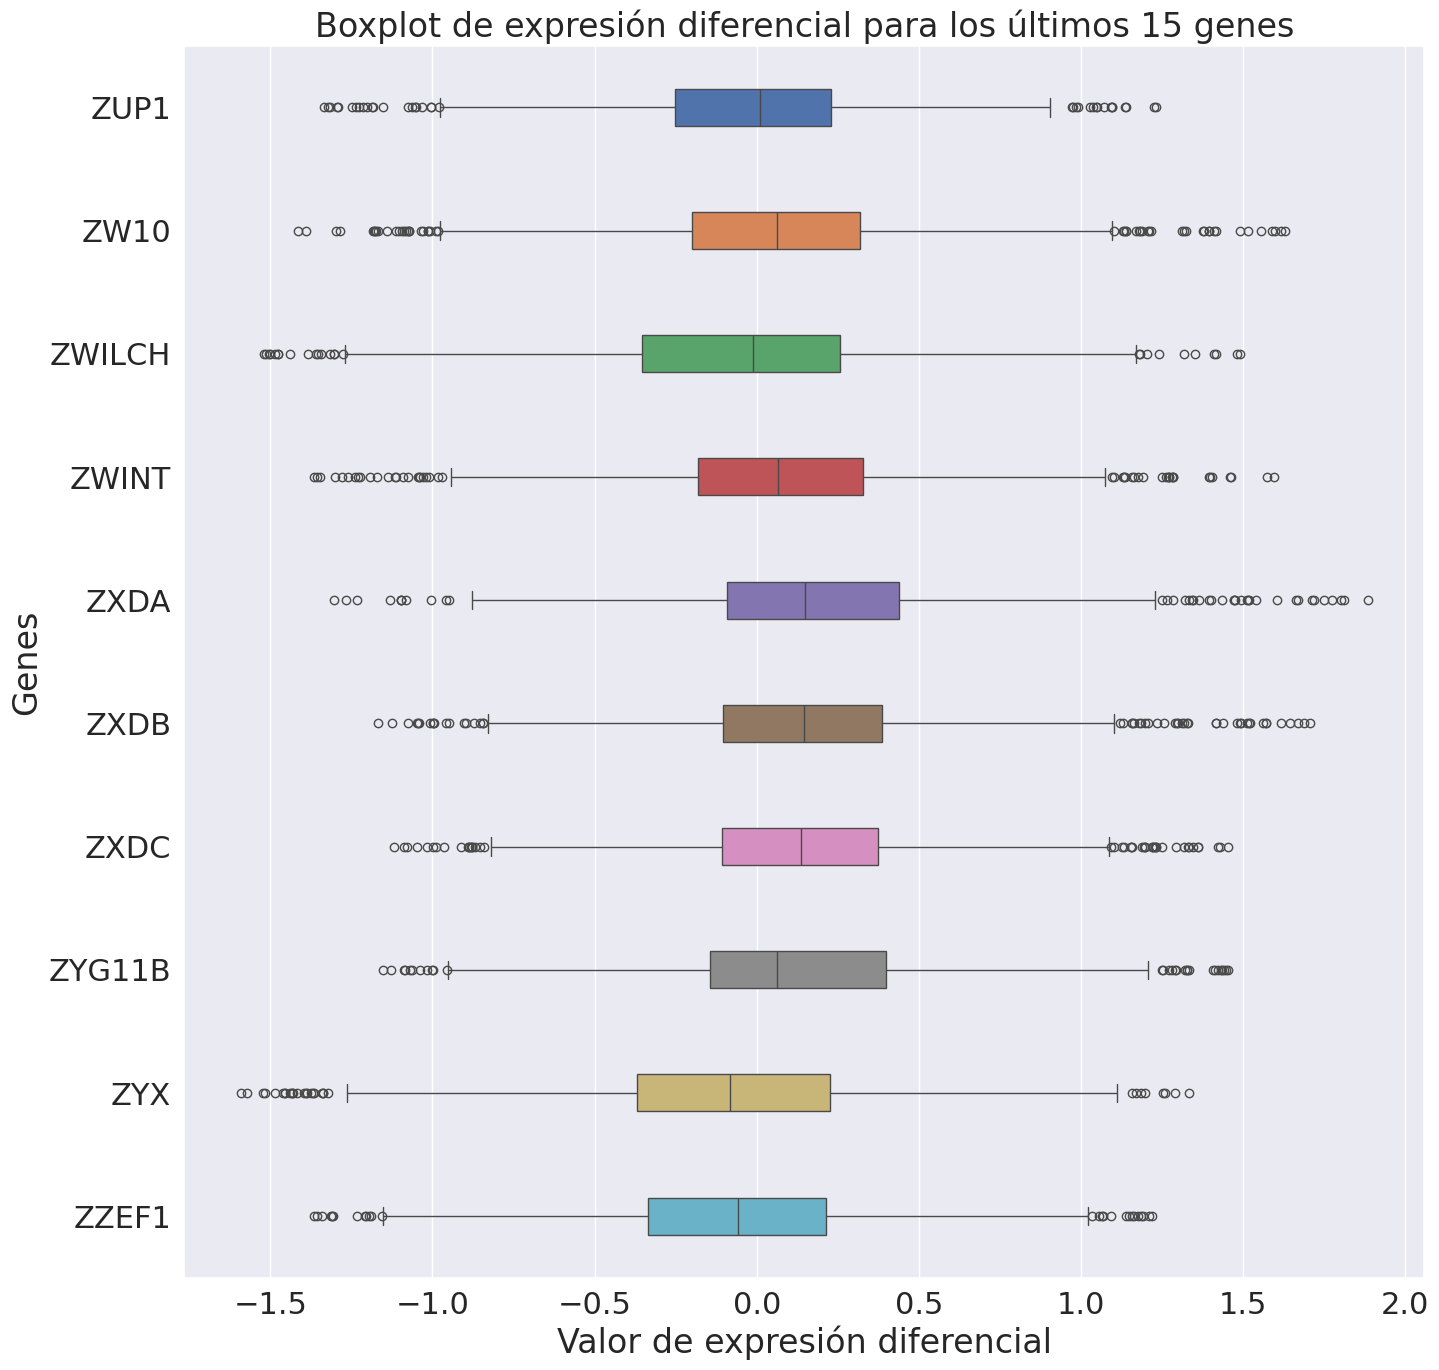

In [32]:
genes = df_de_train.iloc[:, 18201:18216]
sns.set(font_scale = 2)
plt.figure(figsize = (16, 16))
sns.boxplot(data=genes, width=0.3, saturation=0.9, orient = "h")
plt.title('Boxplot de expresión diferencial para los últimos 15 genes')
plt.xlabel('Valor de expresión diferencial')
plt.ylabel('Genes')
plt.show()

Después de realizar la imputación de los valores atípicos, observamos en ambas gráficas que las distribuciones de la expresión diferencial se han estabilizado, con menos dispersión extrema en comparación con las gráficas anteriores. Aunque todavía existen algunos datos atípicos en ciertos genes, como ZZEF1 y A4GALT, estos son mucho menos pronunciados y se encuentran más cercanos a la mediana de sus respectivas distribuciones.

### **Análisis Bivariado**

#### **Expresión diferencial de 2 genes por tipo de célula**

Para este análisis bivariado, hemos seleccionado dos columnas que representan la expresión diferencial de dos genes ( `A4GALT` y `ZZEF1`), y las hemos combinado con la columna `cell_type`. El DataFrame resultante muestra cómo varía la expresión diferencial de estos genes en función de los diferentes tipos de células

In [33]:
genes_seleccionados = df_de_train.iloc[:, [5, -1]]
resultado = pd.concat([de_train[['cell_type']], genes_seleccionados], axis = 1)
resultado

,cell_type,A4GALT,ZZEF1
0,NK cells,0.073229,0.368755
1,T cells CD4+,0.203559,-0.869887
2,T cells CD8+,-0.480681,-0.259365
3,T regulatory cells,0.718590,-0.085024
4,NK cells,0.131515,0.676629
...,...,...,...
609,T regulatory cells,-0.544709,-0.979951
610,NK cells,0.090954,-0.064760
611,T cells CD4+,-0.061539,-0.337082
612,T cells CD8+,-0.706087,-0.058601


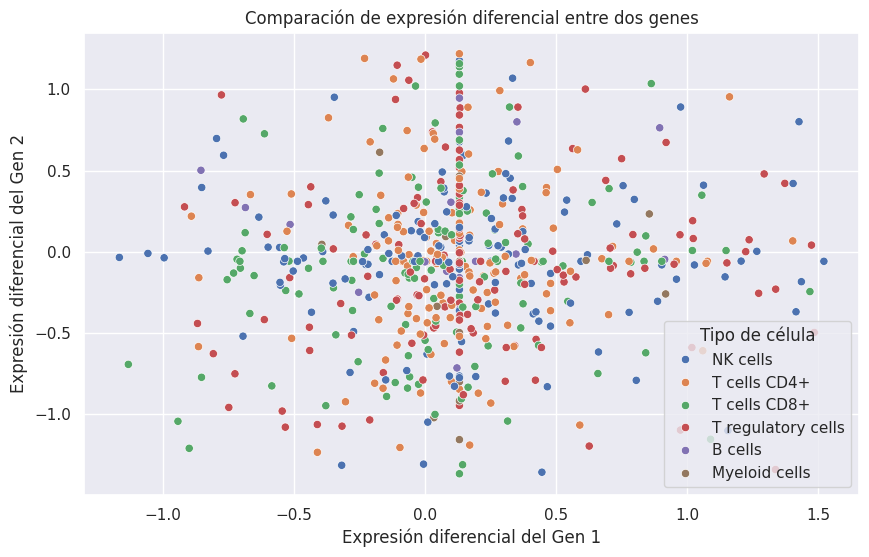

In [34]:
genes_seleccionados = df_de_train.iloc[:, [5, -1]]
resultado = pd.concat([de_train[['cell_type']], genes_seleccionados], axis=1)
resultado.columns = ['cell_type', 'Gen_1', 'Gen_2']

sns.set(font_scale = 1)
plt.figure(figsize = (10, 6))
sns.scatterplot(x = 'Gen_1', y = 'Gen_2', hue = 'cell_type', data = resultado)
plt.title('Comparación de expresión diferencial entre dos genes')
plt.xlabel('Expresión diferencial del Gen 1')
plt.ylabel('Expresión diferencial del Gen 2')
plt.legend(title='Tipo de célula')
plt.show()

Observamos que los valores de expresión diferencial están mayormente concentrados alrededor de cero, lo que indica que no hay un cambio drástico en la mayoría de las células para estos dos genes en particular. Además, se observa una dispersión similar para los distintos tipos de células, lo que sugiere que los genes seleccionados no muestran un patrón claro de variación entre los diferentes tipos de células.

### **Codificación de variables categóricas**

En esta parte se seleccionan las columnas categóricas (`cell_type`, `sm_name`, `control`) que contienen cadenas de texto, y se transforman en variables numéricas utilizando `OneHotEncoder`.

La codificación convierte estas columnas en variables binarias (0 o 1), donde cada valor único en una columna categórica se convierte en una nueva columna.

Finalmente, las nuevas columnas codificadas se añaden al DataFrame original y se eliminan las columnas categóricas originales.

En esta parte del código se eliminan las columnas `sm_lincs_id`, `control` y `SMILES`. Estas columnas no son necesarias para el modelo, ya que no aportan información relevante.

In [97]:
categoricas = ['cell_type', 'sm_name']
encoder = OneHotEncoder(sparse_output = False)
encoded = encoder.fit_transform(de_train[categoricas])
df_encoded = pd.DataFrame(encoded, columns = encoder.get_feature_names_out(categoricas))
de_train_encoded = pd.concat([df_encoded, de_train.drop(columns = categoricas)], axis=1)

In [98]:
de_train_encoded.drop(columns = ['sm_lincs_id'], inplace = True)
de_train_encoded.drop(columns = ['SMILES'], inplace = True)
de_train_encoded.drop(columns = ['control'], inplace = True )

In [99]:
de_train_encoded.head()

,cell_type_B cells,cell_type_Myeloid cells,cell_type_NK cells,cell_type_T cells CD4+,cell_type_T cells CD8+,cell_type_T regulatory cells,sm_name_5-(9-Isopropyl-8-methyl-2-morpholino-9H-purin-6-yl)pyrimidin-2-amine,sm_name_ABT-199 (GDC-0199),sm_name_ABT737,sm_name_AMD-070 (hydrochloride),...,ZUP1,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.227781,-0.010752,-0.023881,0.674536,-0.453068,0.005164,-0.094959,0.034127,0.221377,0.368755
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.494985,-0.303419,0.304955,-0.333905,-0.315516,-0.369626,-0.095079,0.704780,1.096702,-0.869887
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,-0.119422,-0.033608,-0.153123,0.183597,-0.555678,-1.494789,-0.213550,0.415768,0.078439,-0.259365
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.451679,0.704643,0.015468,-0.103868,0.865027,0.189114,0.224700,-0.048233,0.216139,-0.085024
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.758474,0.510762,0.607401,-0.123059,0.214366,0.487838,-0.819775,0.112365,-0.122193,0.676629


Las variables categóricas han sido correctamente transformadas en variables binarias (0 y 1).

In [107]:
de_train_encoded.shape

(614, 18363)

In [110]:
train = de_train_encoded.copy()

Ahora, la base de datos cuenta con **614** filas y **18361** columnas y esta lista para entrenar un modelo con ella.

### **Multicolinealidad**

Debido a que el objetivo del modelo a realizar es predecir cómo las moléculas pequeñas alteran la expresión diferencial de los genes en diferentes tipos de células, aplicar VIF para la reducción de la multicolinealidad podría llevar a la eliminación de genes relevantes para nuestro análisis. Puede que si exitan genes que se correlacionen entre sí pero al tratarse de una cantidad grande de genes es computacionalmente costoso aplicar el VIF. Por otra parte, es posible que haya un subajuste en el modelo sino se entrenan con cada uno de los genes que han sido estipulados en la base de datos.

Además, debido al tamaño de `de_train`, no resulta eficiente desde el punto de vista computacional. Asimismo, eliminar datos puede resultar en una pérdida de información crucial para el desarrollo del modelo y la predicción precisa de la expresión diferencial de los genes.

## **Otros datos de intéres**

Veamos ahora otras dos bases de datos que contienen información relevante que ayuda a la construcción del conjunto de datos de entrenamiento (anteriormente descrito)

## **Base 2: adata_train**

Esta base de datos contiene los datos sin agregar y normalizados en formato de matriz dispersa.

### **Diccionario de variables**

| **Variable**          | **Descripción**                                                                                                                                                               |
|-----------------------|-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **obs_id**            | Identificador único asignado a cada célula en el conjunto de datos sin procesar.                                                                                               |
| **gene**              | Corresponde a las columnas de **de_train**.                                                                                                                                   |
| **count**             | Recuentos moleculares crudos para los datos de expresión génica medidos en el experimento, como se generan en la salida del software 10x CellRanger.                            |
| **normalized_count**  | Estos recuentos han sido normalizados según el tamaño de la biblioteca y transformados con log(X+1).                                                                           |


### **Base de datos**

Inicialmente se hace el cargue del conjunto de datos con el uso de la librería `pandas` y el módulo **`read_parquet`** para leer el archivo en formato `Parquet`.

In [6]:
# adata_train = pd.read_parquet('adata_train.parquet')
adata_train = pd.read_parquet('C:/Users/kamac/OneDrive/Desktop/MachineLearningUN/adata_train.parquet')

### **Características de la base de datos**

Ahora, se hace uso del método `head()` para visualizar las primeras 5 observaciones de la base de datos

In [88]:
adata_train.head()

,obs_id,gene,count,normalized_count
0,000006a87ba75b72,AATF,1,5.567933
1,000006a87ba75b72,ABHD12,1,5.567933
2,000006a87ba75b72,ABHD3,1,5.567933
3,000006a87ba75b72,AC004687.1,1,5.567933
4,000006a87ba75b72,AC009779.2,1,5.567933


Con el uso del método `info()` y `shape` se puede observar una visión general de las características de la base de datos.

In [89]:
adata_train.shape

(416442312, 4)

In [90]:
adata_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 416442312 entries, 0 to 416442311
Data columns (total 4 columns):
 #   Column            Dtype  
---  ------            -----  
 0   obs_id            object 
 1   gene              object 
 2   count             uint16 
 3   normalized_count  float32
dtypes: float32(1), object(2), uint16(1)
memory usage: 8.5+ GB


Este conjunto de datos contiene **416442312** filas y **4** columnas

### **Variables categóricas**

In [91]:
adata_train.describe(include = 'object')

,obs_id,gene
count,416442312,416442312
unique,240090,21255
top,0161fdbef3aa6b07,B2M
freq,6239,240088


#### **Variable categórica: gene**

In [94]:
adata_train['gene'].value_counts().head()

,count
gene,
B2M,240088
RPL41,240087
MT-RNR2,240086
TPT1,240085
MALAT1,240082


In [95]:
adata_train['gene'].value_counts().tail()

,count
gene,
RGS7,1
TAL1,1
AC105235.1,1
AL157895.1,1
AC129502.1,1


Los resultados muestran los genes más y menos representados en el dataset `adata_train`. Los genes como **B2M**, **RPL41** y **MT-RNR2** tienen más de 240,000 observaciones, indicando que fueron ampliamente medidos. En contraste, genes como **RGS7** y **TAL1** tienen solo una observación, lo que sugiere menor relevancia o presencia en el experimento.

### **Variables numéricas**

In [92]:
adata_train.describe()

,count,normalized_count
count,4.164423e+08,4.164423e+08
mean,3.548138e+00,5.518731e+00
std,1.497948e+01,9.743412e-01
min,1.000000e+00,3.536117e+00
25%,1.000000e+00,5.041668e+00
50%,1.000000e+00,5.344550e+00
75%,2.000000e+00,5.825185e+00
max,1.471000e+04,1.350578e+01


#### **Variable numérica: Count**

La variable `count` corresponde a los recuentos moleculares crudos para los datos de expresión génica medidos en el experimento.

In [ ]:
adata_train['count'].describe()

,count
count,4.164423e+08
mean,3.548138e+00
std,1.497948e+01
min,1.000000e+00
25%,1.000000e+00
50%,1.000000e+00
75%,2.000000e+00
max,1.471000e+04


El resumen estadístico de la variable count muestra la distribución de los recuentos moleculares crudos en el dataset de expresión génica. Hay un total de aproximadamente 416 millones de valores con un valor promedio de 3.55, lo que sugiere que la mayoría de los genes tienen bajos niveles de expresión. El valor mínimo es 1, mientras que el máximo alcanza 14.710, indicando una gran variabilidad en los niveles de expresión entre los diferentes genes. Por otra parte, el 25% de los datos tiene un conteo crudo menor o igual a 1 mientras que el otro 75% restante de los datos tiene un conteo crudo mayor o igual a 1

Veamos esto gráficamente

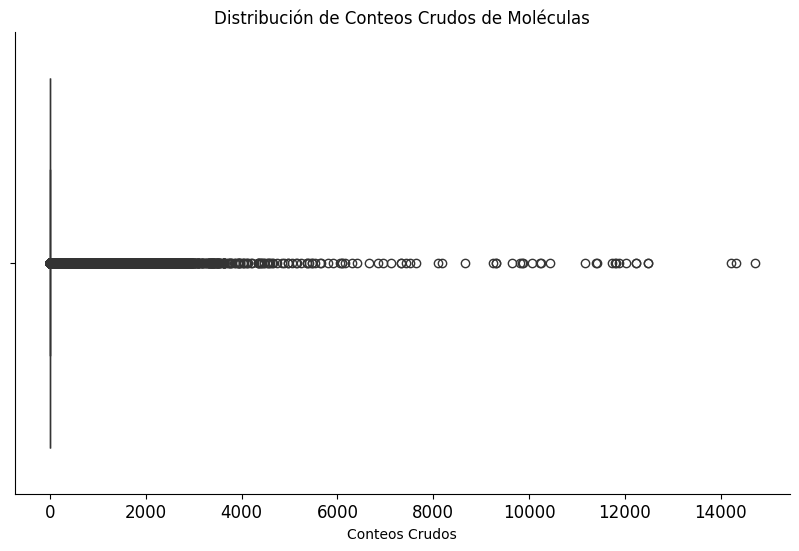

In [7]:
plt.figure(figsize=(10, 6))
sns.boxplot(x = adata_train['count'], color = '#68228B')
plt.title('Distribución de Conteos Crudos de Moléculas')
plt.xlabel('Conteos Crudos')
plt.ylabel('')
plt.xticks(fontsize=12)
sns.despine()
plt.show()


Al graficar esta variable se puede veru una concentración de datos a la izquierda de la gráfica, lo que confirma un sesgo a la derecha. Además hay presencia de muchos datos atípicos.

#### **Variable numérica: normalized count**

La variable `normalized_count` representa los conteos moleculares que han sido ajustados mediante normalización y transformados logarítmicamente. Este proceso ayuda a reducir el sesgo que se observa en la variable `count`, lo que permite una mejor comparabilidad entre los diferentes genes y facilita su análisis.

In [ ]:
adata_train['normalized_count'].describe()

,normalized_count
count,4.164423e+08
mean,5.518731e+00
std,9.743412e-01
min,3.536117e+00
25%,5.041668e+00
50%,5.344550e+00
75%,5.825185e+00
max,1.350578e+01


Al analizar las principales medidas estadísticas de esta variable notamos que media de estos valores es 5.52, con una desviación estándar de 0.97, lo que indica una baja variabilidad. El valor mínimo es 3.54 y el máximo es 13.51. Los percentiles muestran que el 25% de los valores son menores a 5.04, el 50% de los valores son menores a 5.34, y el 75% de los valores son menores a 5.83, lo que sugiere una distribución concentrada en torno a la media.

Veamoslo gráficamente

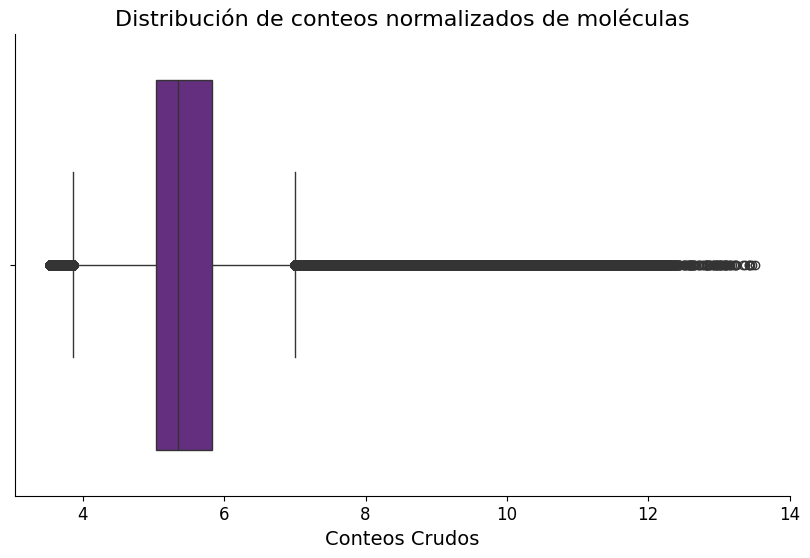

In [8]:
plt.figure(figsize=(10, 6))
sns.boxplot(x = adata_train['normalized_count'], color = '#68228B')
plt.title('Distribución de conteos normalizados de moléculas', fontsize=16)
plt.xlabel('Conteos Crudos', fontsize=14)
plt.ylabel('')
plt.xticks(fontsize=12)
sns.despine()
plt.show()

Nótese que aunque los conteos fueron normalizados, en el diagrama de cajas se observa la presencia de muchos valores atípicos llegando hasta a una valor cercano a 14. Por otra parte, la mayoría de los datos están concentrados en el rango cercano a la mediana, que es aproximadamente 5.

### **Datos faltantes**

El método `adata_train.isnull().sum().sort_values(ascending=False)` se utiliza para identificar y contar los valores nulos en cada columna del DataFrame.

In [116]:
adata_train.isnull().sum().sort_values(ascending = False)

,0
obs_id,0
gene,0
count,0
normalized_count,0


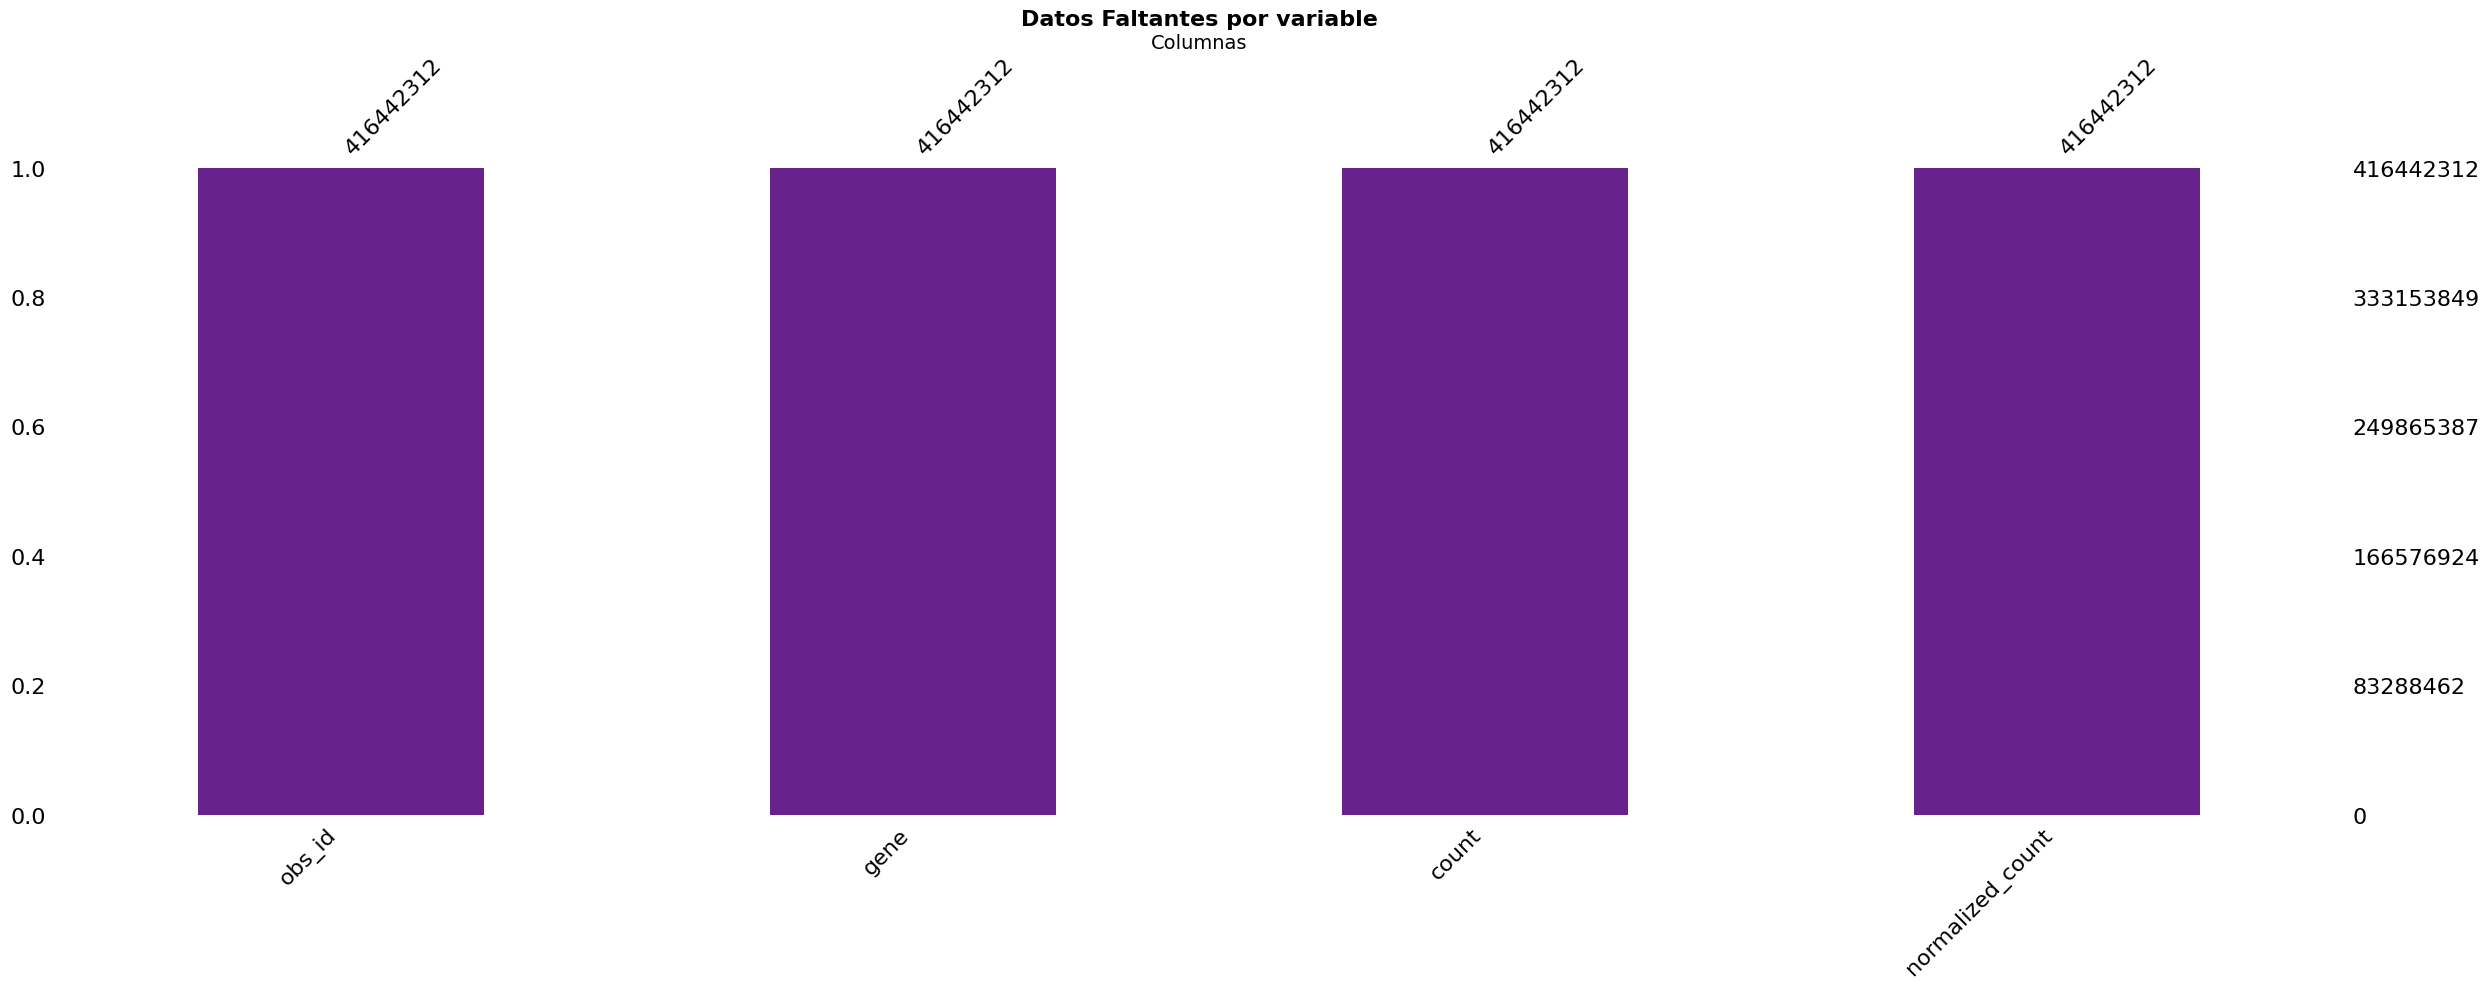

In [117]:
msno.bar(adata_train, color = "#68228B", sort = 'ascending')
plt.title('Datos Faltantes por variable', fontsize = 16, fontweight = 'bold')
plt.xlabel('Columnas', fontsize = 14)
plt.ylabel('Porcentaje de Datos Faltantes', fontsize = 14)
plt.xticks(rotation = 45)
plt.tight_layout()
plt.show()

En este caso, el resultado muestra que no hay valores nulos en ninguna columna, ya que todas tienen un recuento de 0 y las barras estan todas completas, lo que indica que los datos están completos.

## **Base 3: adata_obs_meta**


Esta base de datos contiene metadatos (datos acerca de los datos) sobre `adata_train`

### **Diccionario de variables**

| **Variable**       | **Descripción**                                                                                                                                                             |
|--------------------|-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **library_id**      | Identificador único para cada biblioteca, que corresponde a una medición realizada en muestras agrupadas de cada fila de la placa. Todas las células de la misma fila y placa comparten el mismo library_id.         |
| **plate_name**      | ID único para todas las muestras de la misma placa.                                                                                                                          |
| **well**            | Ubicación del pozo de la muestra en cada placa. Es una concatenación de la fila y la columna.                                                                                 |
| **row**             | Fila de la placa de donde proviene la muestra.                                                                                                                               |
| **col**             | Columna de la placa de donde proviene la muestra.                                                                                                                            |
| **donor_id**        | Identifica la fuente del donante de la muestra (uno de tres donantes).                                                                                                       |
| **cell_type**       | Tipo de célula anotado de cada célula basado en la expresión de ARN. Esto coincide con el **cell_type** en **de_train.parquet**.                                               |
| **cell_id**         | Incluido para mantener la coherencia con los metadatos del Mapa de Conectividad de LINCS, que indica un **cell_id** para cada línea celular.                                   |
| **sm_name**         | Nombre principal del compuesto (padre) en una representación estandarizada elegida por LINCS. Se utiliza para mapear los datos de este experimento con los datos del Mapa de Conectividad de LINCS.                  |
| **sm_lincs_id**     | ID global de LINCS del compuesto (padre) en una representación estandarizada. Se utiliza para mapear los datos de este experimento con los datos del Mapa de Conectividad de LINCS.                                 |
| **SMILES**          | Representaciones SMILES (sistema de entrada simplificado de línea de entrada molecular) de los compuestos utilizados en el experimento. Es una representación 1D de la estructura molecular.                        |
| **dose_uM**         | Dosis del compuesto en una escala micro-molar. Esto se asigna al campo **pert_idose** en LINCS.                                                                               |
| **timepoint_hr**    | Duración del tratamiento en horas. Esto se asigna al campo **pert_itime** en LINCS.                                                                                           |
| **control**         | Indica si esta observación se utilizó como control (True o False).                                                                                                           |


### **Base de datos**

In [6]:
# adata_obs_meta = pd.read_csv('adata_obs_meta.csv')

adata_obs_meta = pd.read_csv('C:/Users/kamac/OneDrive/Desktop/MachineLearningUN/adata_obs_meta.csv')

### **Características de los datos**

Inicialmente se visualizan las primeras 5 observaciones del conjunto de datos.

In [11]:
adata_obs_meta.head()

,obs_id,library_id,plate_name,well,row,col,cell_id,donor_id,cell_type,sm_lincs_id,sm_name,SMILES,dose_uM,timepoint_hr,control
0,000006a87ba75b72,library_4,plate_4,F7,F,7,PBMC,donor_2,T cells CD4+,LSM-4944,MLN 2238,CC(C)C[C@H](NC(=O)CNC(=O)c1cc(Cl)ccc1Cl)B(O)O,1.0,24,False
1,0000233976e3cd37,library_0,plate_3,D4,D,4,PBMC,donor_1,T cells CD4+,LSM-46203,BMS-265246,CCCCOc1c(C(=O)c2c(F)cc(C)cc2F)cnc2[nH]ncc12,1.0,24,False
2,0001533c5e876362,library_2,plate_0,B11,B,11,PBMC,donor_0,T regulatory cells,LSM-45663,Resminostat,CN(C)Cc1ccc(S(=O)(=O)n2ccc(/C=C/C(=O)NO)c2)cc1,1.0,24,False
3,00022f989630d14b,library_35,plate_2,E6,E,6,PBMC,donor_0,T cells CD4+,LSM-43216,FK 866,O=C(/C=C/c1cccnc1)NCCCCC1CCN(C(=O)c2ccccc2)CC1,1.0,24,False
4,0002560bd38ce03e,library_22,plate_4,B6,B,6,PBMC,donor_2,T cells CD4+,LSM-1099,Nilotinib,Cc1cn(-c2cc(NC(=O)c3ccc(C)c(Nc4nccc(-c5cccnc5)...,1.0,24,False


In [12]:
adata_obs_meta.shape

(240090, 15)

In [13]:
adata_obs_meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240090 entries, 0 to 240089
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   obs_id        240090 non-null  object 
 1   library_id    240090 non-null  object 
 2   plate_name    240090 non-null  object 
 3   well          240090 non-null  object 
 4   row           240090 non-null  object 
 5   col           240090 non-null  int64  
 6   cell_id       240090 non-null  object 
 7   donor_id      240090 non-null  object 
 8   cell_type     240090 non-null  object 
 9   sm_lincs_id   240090 non-null  object 
 10  sm_name       240090 non-null  object 
 11  SMILES        240090 non-null  object 
 12  dose_uM       240090 non-null  float64
 13  timepoint_hr  240090 non-null  int64  
 14  control       240090 non-null  bool   
dtypes: bool(1), float64(1), int64(2), object(11)
memory usage: 25.9+ MB


La base de datos **`adata_obs_meta`** contiene **240,090** filas y **15** columnas. De la información de la base de datos podemos decir que todos los campos tienen valores completos, es decir, no hay valores faltantes. Las columnas incluyen identificadores como **`obs_id`**, **`library_id`**, y **`cell_id`**, además de características clave como **`cell_type`** (tipo de célula), **`sm_name`** (nombre del compuesto), y medidas como **`dose_uM`** (dosis en micromolar) y **`timepoint_hr`** (tiempo de tratamiento en horas). También se incluye una columna booleana, **`control`**, que indica si la observación corresponde a un control.

### **Variables categóricas**

In [14]:
adata_obs_meta.describe(include = 'object')

,obs_id,library_id,plate_name,well,row,cell_id,donor_id,cell_type,sm_lincs_id,sm_name,SMILES
count,240090,240090,240090,240090,240090,240090,240090,240090,240090,240090,240090
unique,240090,48,6,96,8,1,3,6,147,147,147
top,ffffe67500d95d8d,library_8,plate_4,A3,A,PBMC,donor_2,T cells CD4+,LSM-36361,Dimethyl Sulfoxide,C[S+](C)[O-]
freq,1,6566,44550,4238,33695,240090,84442,124971,28462,28462,28462


Al usar el método `describe(includ = object)` notamos algunas características importantes:

- Las variables `row`y `col` son la descomposición de la variable `well`. Donde `row` representa la letra y `col` representa el número.

- La variable `cell_id`, cuyo valor es el mismo en todas las observaciones: PBMC, corresponde a las células mononucleares de sangre periférica. Esta variable agrupa diferentes tipos de células ya mencionados en el dataset `de_train`.

- Nótese que las últimas 4 columnas (`cell_type`,`sm_lincs_id`,	`sm_name`,	`SMILES`) de este DataFrame corresponden a las 4 primeras columnas del DataFrame ya estudiado anteriormente `de_train`, con una diferencia clave de 147 registros únicos, es decir, cuenta con un compuesto más que en el conjunto de datos `de_train`.

Ahora, veamos las demás variables por separado para ver sus comportamientos.

#### **Variable categórica: Library_id**

La variable `library_id` representa el identificador único de cada biblioteca, donde cada una corresponde a una medición realizada en muestras agrupadas de cada fila de la placa. Todas las células provenientes de la misma fila y placa comparten el mismo `library_id`.

In [8]:
adata_obs_meta['library_id'].value_counts().head()

,count
library_id,
library_8,6566
library_23,6328
library_22,6269
library_7,6095
library_10,6031


In [9]:
adata_obs_meta['library_id'].value_counts().tail()

,count
library_id,
library_42,4298
library_29,4145
library_43,4051
library_27,3857
library_6,3741


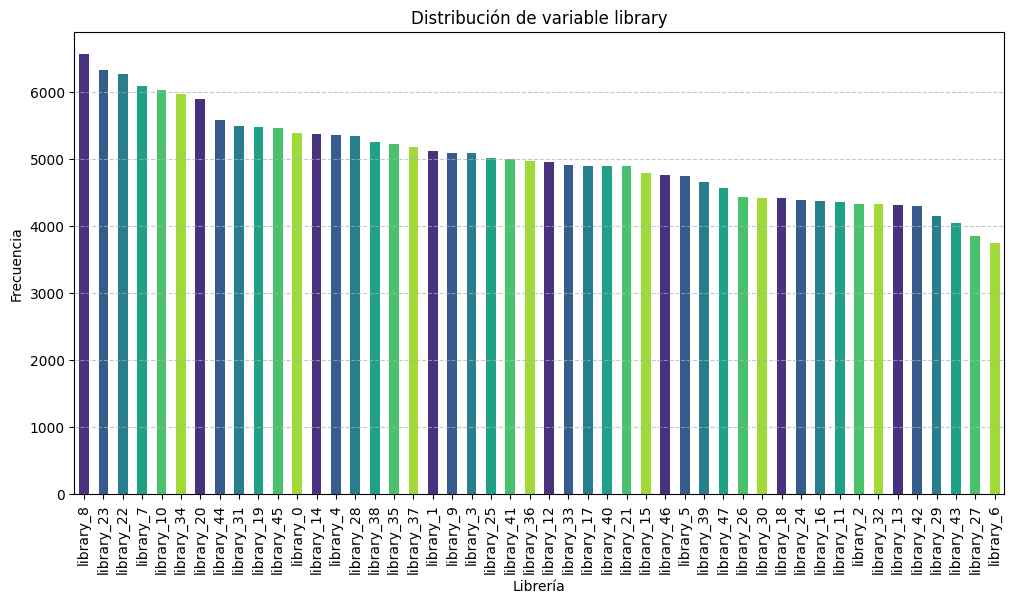

In [24]:
colors = sns.color_palette("viridis")
plt.figure(figsize = (12, 6))
adata_obs_meta['library_id'].value_counts().plot(kind = 'bar', color = colors)
plt.title('Distribución de variable library')
plt.xlabel('Librería')
plt.ylabel('Frecuencia')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()



En este caso, se observa que los valores más frecuentes pertenecen a bibliotecas como `library_8`, `library_23`, y `library_22`, las cuales presentan entre **6000** y **6500** entradas, mientras que otras bibliotecas como `library_6`, `library_27`, y `library_43` tienen frecuencias más bajas, rondando entre **3700** y **4300** entradas. Esto indica que la distribución de muestras entre las distintas bibliotecas es desigual, con algunas bibliotecas teniendo un mayor número de entradas que otras.

#### **Variable categórica: plate_name**

La variable `plate_name` corresponde al identificador único de cada una de las placas utilizadas en el experimento. Cada placa contiene múltiples muestras que han sido agrupadas para las mediciones. En este caso, existen seis placas en total, cada una con una cantidad diferente de observaciones.

In [15]:
adata_obs_meta['plate_name'].value_counts()

,count
plate_name,
plate_4,44550
plate_3,41881
plate_1,39892
plate_5,39669
plate_2,37914
plate_0,36184


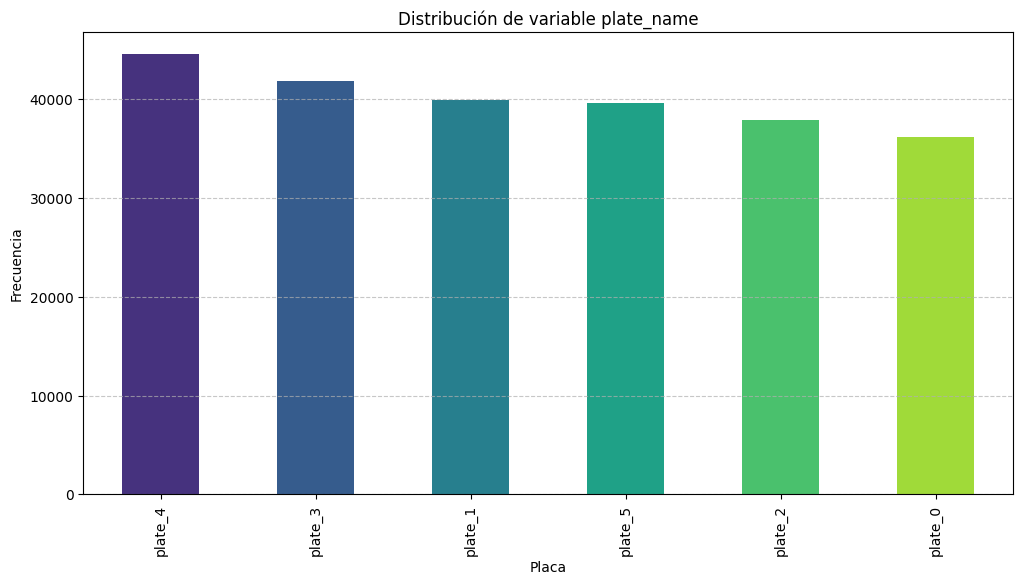

In [23]:
plt.figure(figsize = (12, 6))
adata_obs_meta['plate_name'].value_counts().plot(kind = 'bar', color = colors)
plt.title('Distribución de variable plate_name')
plt.xlabel('Placa')
plt.ylabel('Frecuencia')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Al analizar esta variable se puede decir que la placa más utilizada es la `plate_4` con **44.550** observaciones, mientras que la `plate_0` es la que contiene menos observaciones con **36.184**.

#### **Variable categórica: well**

La variable `well` representa la ubicación de las muestras en cada pozo de una placa de 96 pocillos, que es comúnmente utilizada en experimentos de laboratorio para organizar y tratar diferentes muestras. Cada pozo se identifica por una combinación de fila (`row`) y columna (`col`), y agrupa una cantidad de observaciones, en este caso, correspondientes a células mononucleares de sangre periférica (PBMC). A continuación, el gráfico muestra la distribución de observaciones por cada uno de estos pozos.

In [20]:
adata_obs_meta['well'].value_counts()

,count
well,
A3,4238
H3,4013
B3,3875
B2,3806
C3,3674
...,...
G12,1738
C10,1616
F7,1408


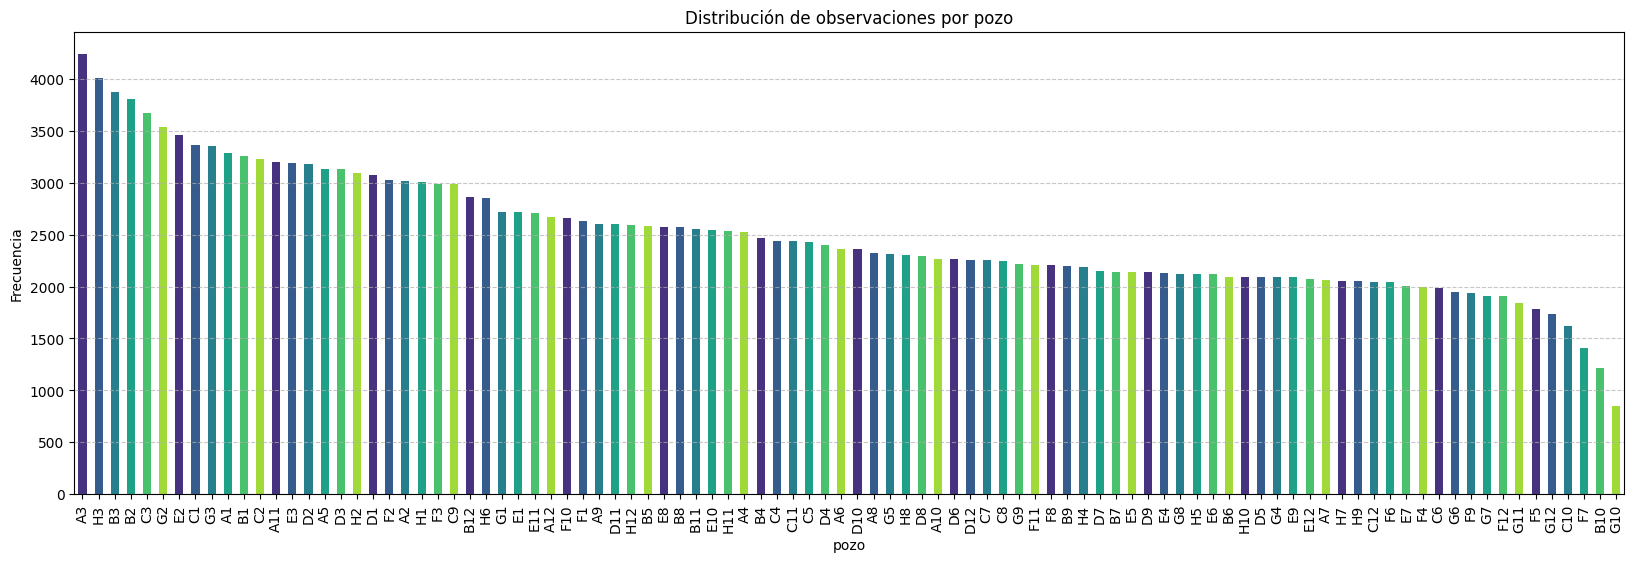

In [25]:
plt.figure(figsize=(20, 6))
adata_obs_meta['well'].value_counts().plot(kind = 'bar', color = colors)
plt.title('Distribución de observaciones por pozo')
plt.xlabel('pozo')
plt.ylabel('Frecuencia')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Al analizar la distribución de observaciones por cada pozo de una placa de 96 pocillos utilizada en el experimento podemos concluir que los pozos **A3**, **H3** y **B3** son los que tienen la mayor cantidad de observaciones, mientras que pozos como **G10**, **B10** y **F7** tienen una menor cantidad.

#### **Variable categórica: donor_id**

In [26]:
adata_obs_meta['donor_id'].value_counts()

,count
donor_id,
donor_2,84442
donor_1,81550
donor_0,74098


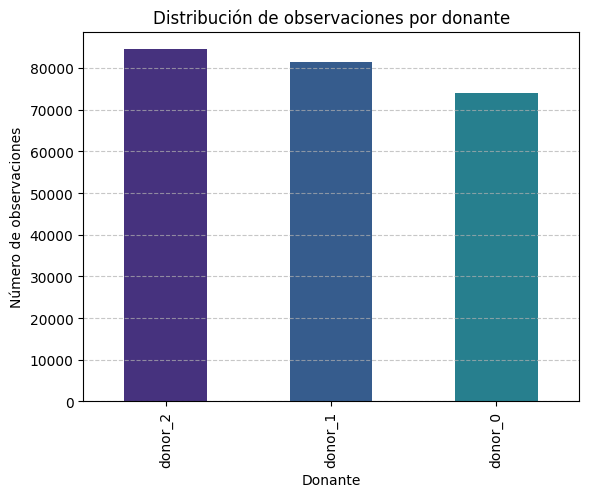

In [28]:
adata_obs_meta['donor_id'].value_counts().plot(kind='bar', color = colors)
plt.title('Distribución de observaciones por donante')
plt.xlabel('Donante')
plt.ylabel('Número de observaciones')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Luego de haber analizado la variable `donor_id` se observa que el **donante 2** tiene la mayor cantidad de observaciones, seguido de **donante 1** y **donante 0**. Aunque hay una ligera diferencia en el número de observaciones entre los tres, estas se distribuyen de manera relativamente uniforme.

### **Variables numéricas**

In [15]:
adata_obs_meta.describe()

,col,dose_uM,timepoint_hr
count,240090.00000,240090.000000,240090.0
mean,6.05665,2.462781,24.0
std,3.55246,4.276144,0.0
min,1.00000,0.100000,24.0
25%,3.00000,1.000000,24.0
50%,6.00000,1.000000,24.0
75%,9.00000,1.000000,24.0
max,12.00000,14.100000,24.0


Al utilizar el método `describe()` notamos las siguientes características para las variables numéricas de este DataFrame:

- La variable `col`, mencionada anteriormente, hace parte de la composición de la variable `well`

- La variable `tiempoint_hr` que corresponde a la duración del tratamiento en horas indica que cada uno de los tratamientos duro 24 horas.

#### **Variable numérica: dose_uM**


Del anterior `describe`se puede decir que las dosis administradas varían entre **0.1** y **14.1** micromolares **(µM)**, donde una micromolar es equivalente a una millonésima de mol por litro. En promedio, la dosis es de aproximadamente **2.46 µM**, con una desviación estándar de **4.28**, lo que indica una alta variabilidad en las dosis aplicadas. El **75%** de los valores son inferiores a **1** µM, mientras que el **25% **restante presenta dosis entre **1** y **14.1** µM.

In [30]:
adata_obs_meta['dose_uM'].value_counts()

,count
dose_uM,
1.0,187569
14.1,28462
0.1,24059


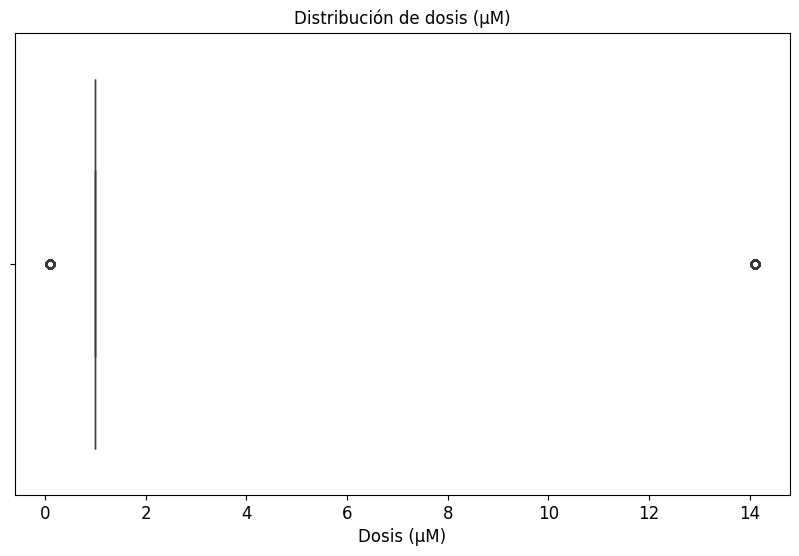

In [32]:
plt.figure(figsize=(10, 6))
sns.boxplot(x = adata_obs_meta['dose_uM'], color = '#7A378B' )
plt.title('Distribución de dosis (µM)', fontsize = 12)
plt.xlabel('Dosis (µM)', fontsize = 12)
plt.ylabel('')
plt.xticks(fontsize=12)
plt.show()


La variable `dose_uM` presenta tres valores únicos de dosis (**0.1, 1.0** y **14.1** micromolares). La mayoría de las observaciones **(187569)** corresponden a una dosis de **1.0 µM**, mientras que **28462** y **24059** observaciones se distribuyen en las dosis de **14.1** y **0.1** µM, respectivamente. En el gráfico de caja, se observa que los datos están altamente concentrados en **1.0** µM, lo que genera un gráfico con pocos datos fuera de este rango, específicamente en las dosis extremas de **0.1** y **14.1** µM, resaltando la presencia de datos atípicos.

### **Análisis Bivariado**

#### **Análisis de la distribución de las dosis por tipo de célula**

In [42]:
grouped_data = adata_obs_meta.groupby('cell_type', observed=True)['dose_uM'].agg(
    ['mean', 'median', 'std', 'min', 'max', 'count'])

In [43]:
grouped_data

,mean,median,std,min,max,count
cell_type,,,,,,
B cells,4.479277,1.0,6.071753,0.1,14.1,15485
Myeloid cells,5.100708,1.0,6.235596,0.1,14.1,16661
NK cells,2.222814,1.0,3.914845,0.1,14.1,59170
T cells CD4+,2.042275,1.0,3.713876,0.1,14.1,124971
T cells CD8+,2.016295,1.0,3.650461,0.1,14.1,15563
T regulatory cells,2.283495,1.0,3.907974,0.1,14.1,8240


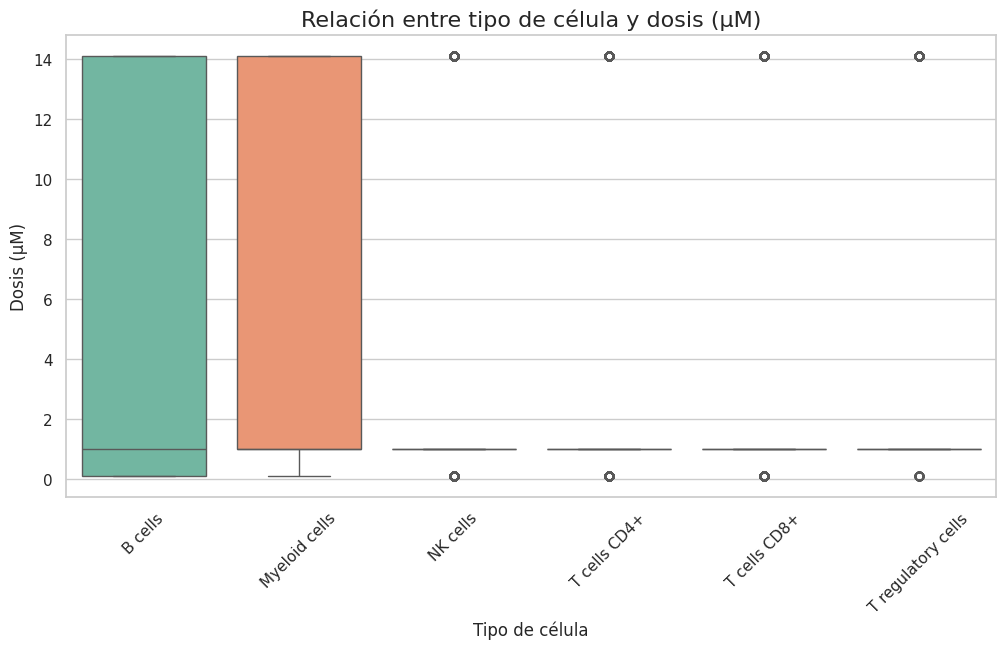

In [36]:
adata_obs_meta['cell_type'] = adata_obs_meta['cell_type'].astype('category')
plt.figure(figsize=(12, 6))
sns.set(style="whitegrid")
sns.boxplot(x='cell_type', y='dose_uM', hue='cell_type', data=adata_obs_meta, palette="Set2", legend=False)
plt.title('Relación entre tipo de célula y dosis (µM)', fontsize=16)
plt.xlabel('Tipo de célula', fontsize=12)
plt.ylabel('Dosis (µM)', fontsize=12)
plt.xticks(rotation=45)
plt.show()


Haciendo un análisis bivariado entre las variables `cell_type` (tipo de célula) y `dose_uM` (dosis en micromolares), se observa que las células B y las células mieloides presentan una mayor variabilidad en las dosis administradas, con una dosis máxima de 14.1 µM y una desviación estándar de 6.07 y 6.23, respectivamente. En cambio, los otros tipos de células, como las NK cells y las T cells, muestran dosis considerablemente más bajas, con un rango de dosis entre 0.1 µM y 1.0 µM, lo que también se refleja en la mediana cercana a 1 µM. Esto sugiere que las células B y mieloides están siendo tratadas con un mayor rango de concentraciones de compuestos en comparación con los otros tipos celulares, lo que podría tener implicaciones en su respuesta a los tratamientos experimentales.

#### **Análisis de la distribución de placas por tipo de célula**

In [45]:
grouped_data2 = adata_obs_meta.groupby(['plate_name', 'cell_type'], observed = True).size().unstack(fill_value = 0)

In [46]:
grouped_data2

cell_type,B cells,Myeloid cells,NK cells,T cells CD4+,T cells CD8+,T regulatory cells
plate_name,,,,,,
plate_0,3506,2609,7612,19540,1933,984
plate_1,1907,2785,11969,19355,2251,1625
plate_2,3573,2586,6751,21684,1732,1588
plate_3,2428,2678,10452,22323,2571,1429
plate_4,2037,3644,13787,20951,2619,1512
plate_5,2034,2359,8599,21118,4457,1102


<Figure size 1200x600 with 0 Axes>

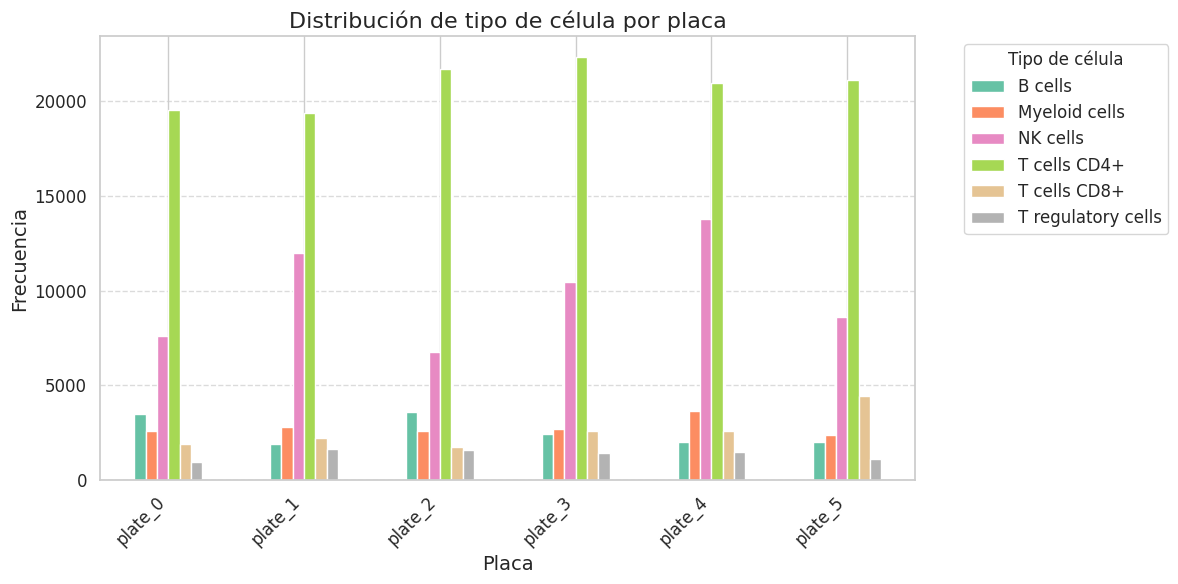

In [48]:
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
ax = grouped_data2.plot(kind='bar', stacked=False, colormap='Set2', figsize=(12, 6))
plt.xlabel('Placa', fontsize = 14)
plt.ylabel('Frecuencia', fontsize = 14)
plt.title('Distribución de tipo de célula por placa', fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Tipo de célula', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Al realizar un análisis bivariado entre las variables `plate_name` y `cell_type`, se observa la distribución de los diferentes tipos de células (como células T CD4+, NK cells, B cells, etc.) en función de las distintas placas (`plate_0`, `plate_1`, etc.).

La tabla muestra los recuentos por tipo de célula en cada placa, revelando una mayor frecuencia de células T CD4+ en todas las placas. El gráfico de barras múltiples refleja esta misma información, mostrando cómo la proporción de los diferentes tipos de células varía ligeramente entre las placas, pero con predominancia de las células T CD4+ en todas ellas.

